# Flavor Transformations

This notebook produces the figures from my Masters' thesis

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from astropy import units as u 

from snewpy.neutrino import Flavor, MassHierarchy, MixingParameters
from snewpy.models import Nakazato_2013, Bollig_2016, Zha_2021
from snewpy.flavor_transformation import NoTransformation, CompleteExchange, AdiabaticMSW, NonAdiabaticMSWH, \
                                         TwoFlavorDecoherence, ThreeFlavorDecoherence, \
                                         NeutrinoDecay, AdiabaticMSWes, NonAdiabaticMSWes

mpl.rc('font', size=18)
%matplotlib inline

/var/folders/3t/mf2g60fx3nb49wp30kcwr8300000gn/T/ipykernel_47211/2230755518.py:8: FutureWarning: snewpy.models.Nakazato_2013 is moved to snewpy.models.ccsn.Nakazato_2013
  from snewpy.models import Nakazato_2013, Bollig_2016, Zha_2021
/var/folders/3t/mf2g60fx3nb49wp30kcwr8300000gn/T/ipykernel_47211/2230755518.py:8: FutureWarning: snewpy.models.Bollig_2016 is moved to snewpy.models.ccsn.Bollig_2016
  from snewpy.models import Nakazato_2013, Bollig_2016, Zha_2021
/var/folders/3t/mf2g60fx3nb49wp30kcwr8300000gn/T/ipykernel_47211/2230755518.py:8: FutureWarning: snewpy.models.Zha_2021 is moved to snewpy.models.ccsn.Zha_2021
  from snewpy.models import Nakazato_2013, Bollig_2016, Zha_2021


In [3]:
model = Nakazato_2013(progenitor_mass=20*u.solMass, revival_time=100*u.ms, metallicity=0.004, eos='shen')
#eos: equation of state, revival time: time the model goes over
model

**Nakazato_2013 Model**: nakazato-shen-z0.004-t_rev100ms-s20.0.fits

|Parameter|Value|
|:--------|:----:|
|Progenitor mass | $20$ $\mathrm{M_{\odot}}$|
|EOS | shen |
|Metallicity | 0.004 |
|Revival time | $100$ $\mathrm{ms}$|

## Untransformed and Transformed Spectra at Earth

Compute and plot the spectra at Earth for a SN at 10 kpc with no flavor transformation, and with the chosen flavor transformation.

In [9]:
def get_flux(d, arrival_time, energies, model): #jost says to make these functions just find the one spectra - more versatile
    
    d = d.to('cm').value
    
    spectra = model.get_initial_spectra(arrival_time, energies) 
    transformed_spectra_nmo = model.get_transformed_spectra(arrival_time, energies, AdiabaticMSW())
    transformed_spectra_imo = model.get_transformed_spectra(arrival_time, energies, AdiabaticMSW(mh=MassHierarchy.INVERTED))

    for flavor in Flavor:
        for j, E in enumerate(energies):
            spectra[flavor][j] /= (4.*np.pi*d**2)
            transformed_spectra_nmo[flavor][j] /= (4.*np.pi*d**2)
            transformed_spectra_imo[flavor][j] /= (4.*np.pi*d**2)
    
    return spectra, transformed_spectra_nmo, transformed_spectra_imo

In [10]:
def get_delayed_flux(d, arrival_time, energies, mass, model): #can be simplified if there's time
    """
    Arguments
        arrival_time: arrival time of neutrinos in the detector
              Same for all neutrinos (independent of energy)
        energies: energy of the neutrinos (this will be a list of different energies)
        mass: neutrino mass
    """
    
    c = 299792458 * (u.m/u.s) #definition of speed of light
    d = d.to('kpc')
    
    init_NU_E = []
    init_NU_X = []
    init_NU_E_BAR = []
    init_NU_X_BAR = []

    nmo_NU_E = []
    nmo_NU_X = []
    nmo_NU_E_BAR = []
    nmo_NU_X_BAR = []

    imo_NU_E = []
    imo_NU_X = []
    imo_NU_E_BAR = []
    imo_NU_X_BAR = []
    
    for energy in energies:
        delta_t = 0.57 * u.ms * (mass/u.eV)**2 * (30 * u.MeV/energy)**2 * (d / (10 * u.kpc))  
        emission_time = arrival_time - delta_t

        result1 = model.get_initial_spectra(emission_time, energy)
        result2 = model.get_transformed_spectra(emission_time, energy, AdiabaticMSW())
        result3 = model.get_transformed_spectra(emission_time, energy, AdiabaticMSW(mh=MassHierarchy.INVERTED))

        init_NU_E.append(result1[0].value)
        init_NU_X.append(result1[1].value)
        init_NU_E_BAR.append(result1[2].value)
        init_NU_X_BAR.append(result1[3].value)
        
        nmo_NU_E.append(result2[0].value)
        nmo_NU_X.append(result2[1].value)
        nmo_NU_E_BAR.append(result2[2].value)
        nmo_NU_X_BAR.append(result2[3].value)
        
        imo_NU_E.append(result3[0].value)
        imo_NU_X.append(result3[1].value)
        imo_NU_E_BAR.append(result3[2].value)
        imo_NU_X_BAR.append(result3[3].value)
        
    delayed_spectra = {
        Flavor.NU_E: init_NU_E / ((4*np.pi*d.to('cm').value**2) * u.erg * u.s),
        Flavor.NU_X: init_NU_X / ((4*np.pi*d.to('cm').value**2) * u.erg * u.s),
        Flavor.NU_E_BAR: init_NU_E_BAR / ((4*np.pi*d.to('cm').value**2) * u.erg * u.s),
        Flavor.NU_X_BAR: init_NU_X_BAR / ((4*np.pi*d.to('cm').value**2) * u.erg * u.s)
        }
    delayed_transformed_spectra_nmo = {
        Flavor.NU_E: nmo_NU_E / ((4*np.pi*d.to('cm').value**2) * u.erg * u.s),
        Flavor.NU_X: nmo_NU_X / ((4*np.pi*d.to('cm').value**2) * u.erg * u.s),
        Flavor.NU_E_BAR: nmo_NU_E_BAR / ((4*np.pi*d.to('cm').value**2) * u.erg * u.s),
        Flavor.NU_X_BAR: nmo_NU_X_BAR / ((4*np.pi*d.to('cm').value**2) * u.erg * u.s)
        }
    delayed_transformed_spectra_imo = {
        Flavor.NU_E: imo_NU_E / ((4*np.pi*d.to('cm').value**2) * u.erg * u.s),
        Flavor.NU_X: imo_NU_X / ((4*np.pi*d.to('cm').value**2) * u.erg * u.s),
        Flavor.NU_E_BAR: imo_NU_E_BAR / ((4*np.pi*d.to('cm').value**2) * u.erg * u.s),
        Flavor.NU_X_BAR: imo_NU_X_BAR / ((4*np.pi*d.to('cm').value**2) * u.erg * u.s)
        }
    
    return delayed_spectra, delayed_transformed_spectra_nmo, delayed_transformed_spectra_imo

[Text(0.5, 0, 'Energy [MeV]')]

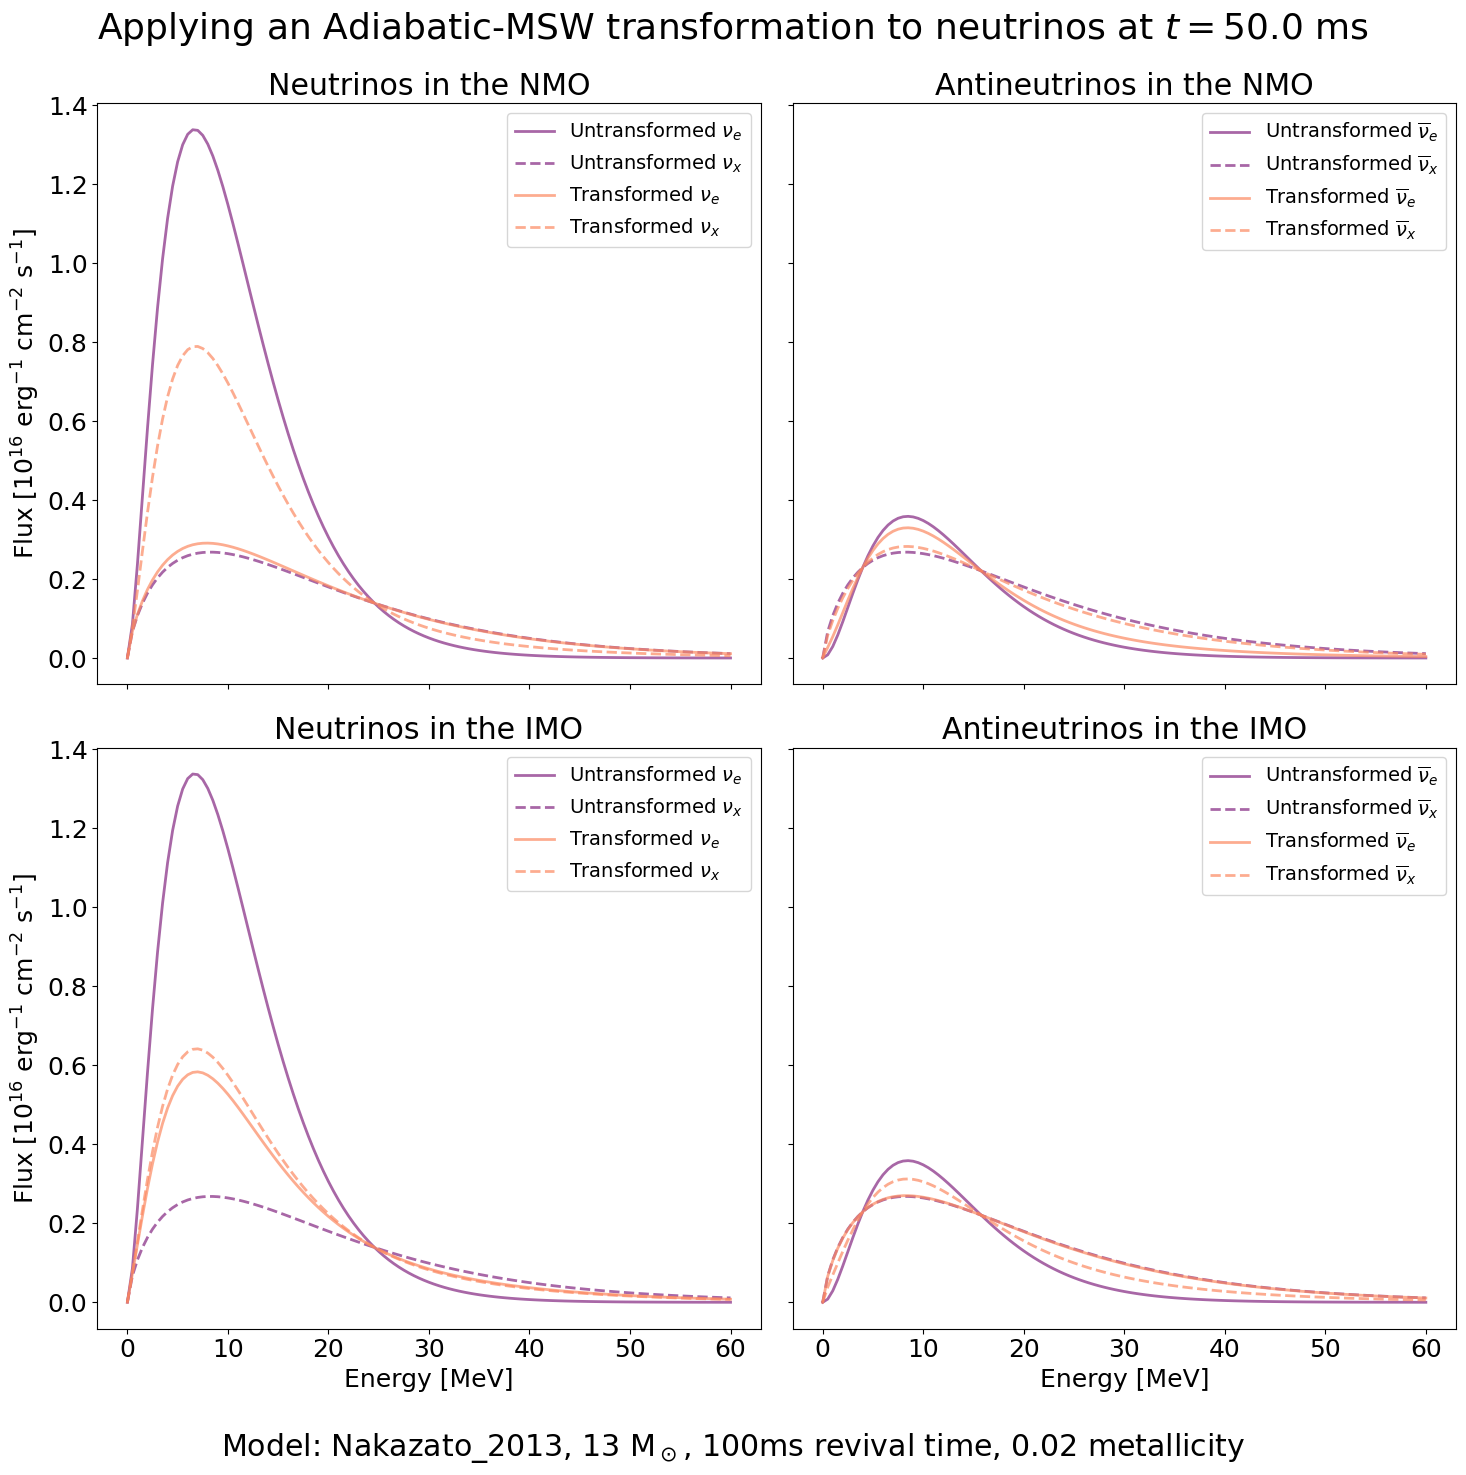

In [12]:
# define supernova model
model = Nakazato_2013(progenitor_mass=13*u.solMass, revival_time=100*u.ms, metallicity=0.02, eos='shen')
#model = Bollig_2016(progenitor_mass=27*u.solMass)
#model = Zha_2021(progenitor_mass=16*u.solMass)


energies = np.linspace(0,60,121) * u.MeV
mass = 1 * u.eV

distance = 10 * u.kpc
arrival_time = 50 * u.ms

delayed_spectra, delayed_transformed_spectra_nmo, delayed_transformed_spectra_imo = get_delayed_flux(distance, arrival_time, energies, mass, model)
spectra, transformed_spectra_nmo, transformed_spectra_imo = get_flux(distance, arrival_time, energies, model)

X = np.linspace(0,1,9)
colors = []
for x in X:
    color = plt.cm.magma(x)
    colors += [color[:3]]

fig, axes = plt.subplots(2,2, figsize=(15,15), sharex=True, sharey=True, tight_layout=True)

for i, spec in enumerate([spectra, transformed_spectra_nmo]):
    axes[0][0].plot(energies, spec[Flavor.NU_E]/1e16, 
                label='Untransformed '+Flavor.NU_E.to_tex() if i==0 else 'Transformed '+Flavor.NU_E.to_tex(),
                color=colors[3] if i==0 else colors[6], ls='-', lw=2,  alpha=0.7)
    axes[0][0].plot(energies, spec[Flavor.NU_X]/1e16, 
                label='Untransformed '+Flavor.NU_X.to_tex() if i==0 else 'Transformed '+Flavor.NU_X.to_tex(),
                color=colors[3] if i==0 else colors[6], ls='--', lw=2,  alpha=0.7)
    
    axes[0][1].plot(energies, spec[Flavor.NU_E_BAR]/1e16, 
                label='Untransformed '+Flavor.NU_E_BAR.to_tex() if i==0 else 'Transformed '+Flavor.NU_E_BAR.to_tex(),
                color=colors[3] if i==0 else colors[6], ls='-', lw=2,  alpha=0.7)
    axes[0][1].plot(energies, spec[Flavor.NU_X_BAR]/1e16, 
                label='Untransformed '+Flavor.NU_X_BAR.to_tex() if i==0 else 'Transformed '+Flavor.NU_X_BAR.to_tex(),
                color=colors[3] if i==0 else colors[6], ls='--', lw=2,  alpha=0.7)

for i, spec in enumerate([spectra, transformed_spectra_imo]):
    axes[1][0].plot(energies, spec[Flavor.NU_E]/1e16, 
                label='Untransformed '+Flavor.NU_E.to_tex() if i==0 else 'Transformed '+Flavor.NU_E.to_tex(),
                color=colors[3] if i==0 else colors[6], ls='-', lw=2,  alpha=0.7)
    axes[1][0].plot(energies, spec[Flavor.NU_X]/1e16, 
                label='Untransformed '+Flavor.NU_X.to_tex() if i==0 else 'Transformed '+Flavor.NU_X.to_tex(),
                color=colors[3] if i==0 else colors[6], ls='--', lw=2,  alpha=0.7)

    axes[1][1].plot(energies, spec[Flavor.NU_E_BAR]/1e16, 
                label='Untransformed '+Flavor.NU_E_BAR.to_tex() if i==0 else 'Transformed '+Flavor.NU_E_BAR.to_tex(),
                color=colors[3] if i==0 else colors[6], ls='-', lw=2,  alpha=0.7)
    axes[1][1].plot(energies, spec[Flavor.NU_X_BAR]/1e16, 
                label='Untransformed '+Flavor.NU_X_BAR.to_tex() if i==0 else 'Transformed '+Flavor.NU_X_BAR.to_tex(),
                color=colors[3] if i==0 else colors[6], ls='--', lw=2,  alpha=0.7)


axes[0][0].legend(loc='upper right', fontsize=14)
axes[0][1].legend(loc='upper right', fontsize=14)
axes[1][0].legend(loc='upper right', fontsize=14)
axes[1][1].legend(loc='upper right', fontsize=14)

fig.suptitle('Applying an Adiabatic-MSW transformation to neutrinos at $t = ${:.1f}'.format(arrival_time), fontsize=26)
fig.supxlabel("Model: Nakazato_2013, 13 M$_\odot$, 100ms revival time, 0.02 metallicity")

axes[0][0].set(title='Neutrinos in the NMO')
axes[0][1].set(title='Antineutrinos in the NMO')
axes[1][0].set(title='Neutrinos in the IMO')
axes[1][1].set(title='Antineutrinos in the IMO')

axes[0][0].set(ylabel=r'Flux [$10^{16}$ erg$^{-1}$ cm$^{-2}$ s$^{-1}$]')
axes[1][0].set(xlabel = r'Energy [MeV]', ylabel=r'Flux [$10^{16}$ erg$^{-1}$ cm$^{-2}$ s$^{-1}$]')
axes[1][1].set(xlabel = r'Energy [MeV]')

#fig.savefig('applying transform.png')

#could focus on just one flavour? make decision 


[Text(0.5, 0, 'Energy [MeV]')]

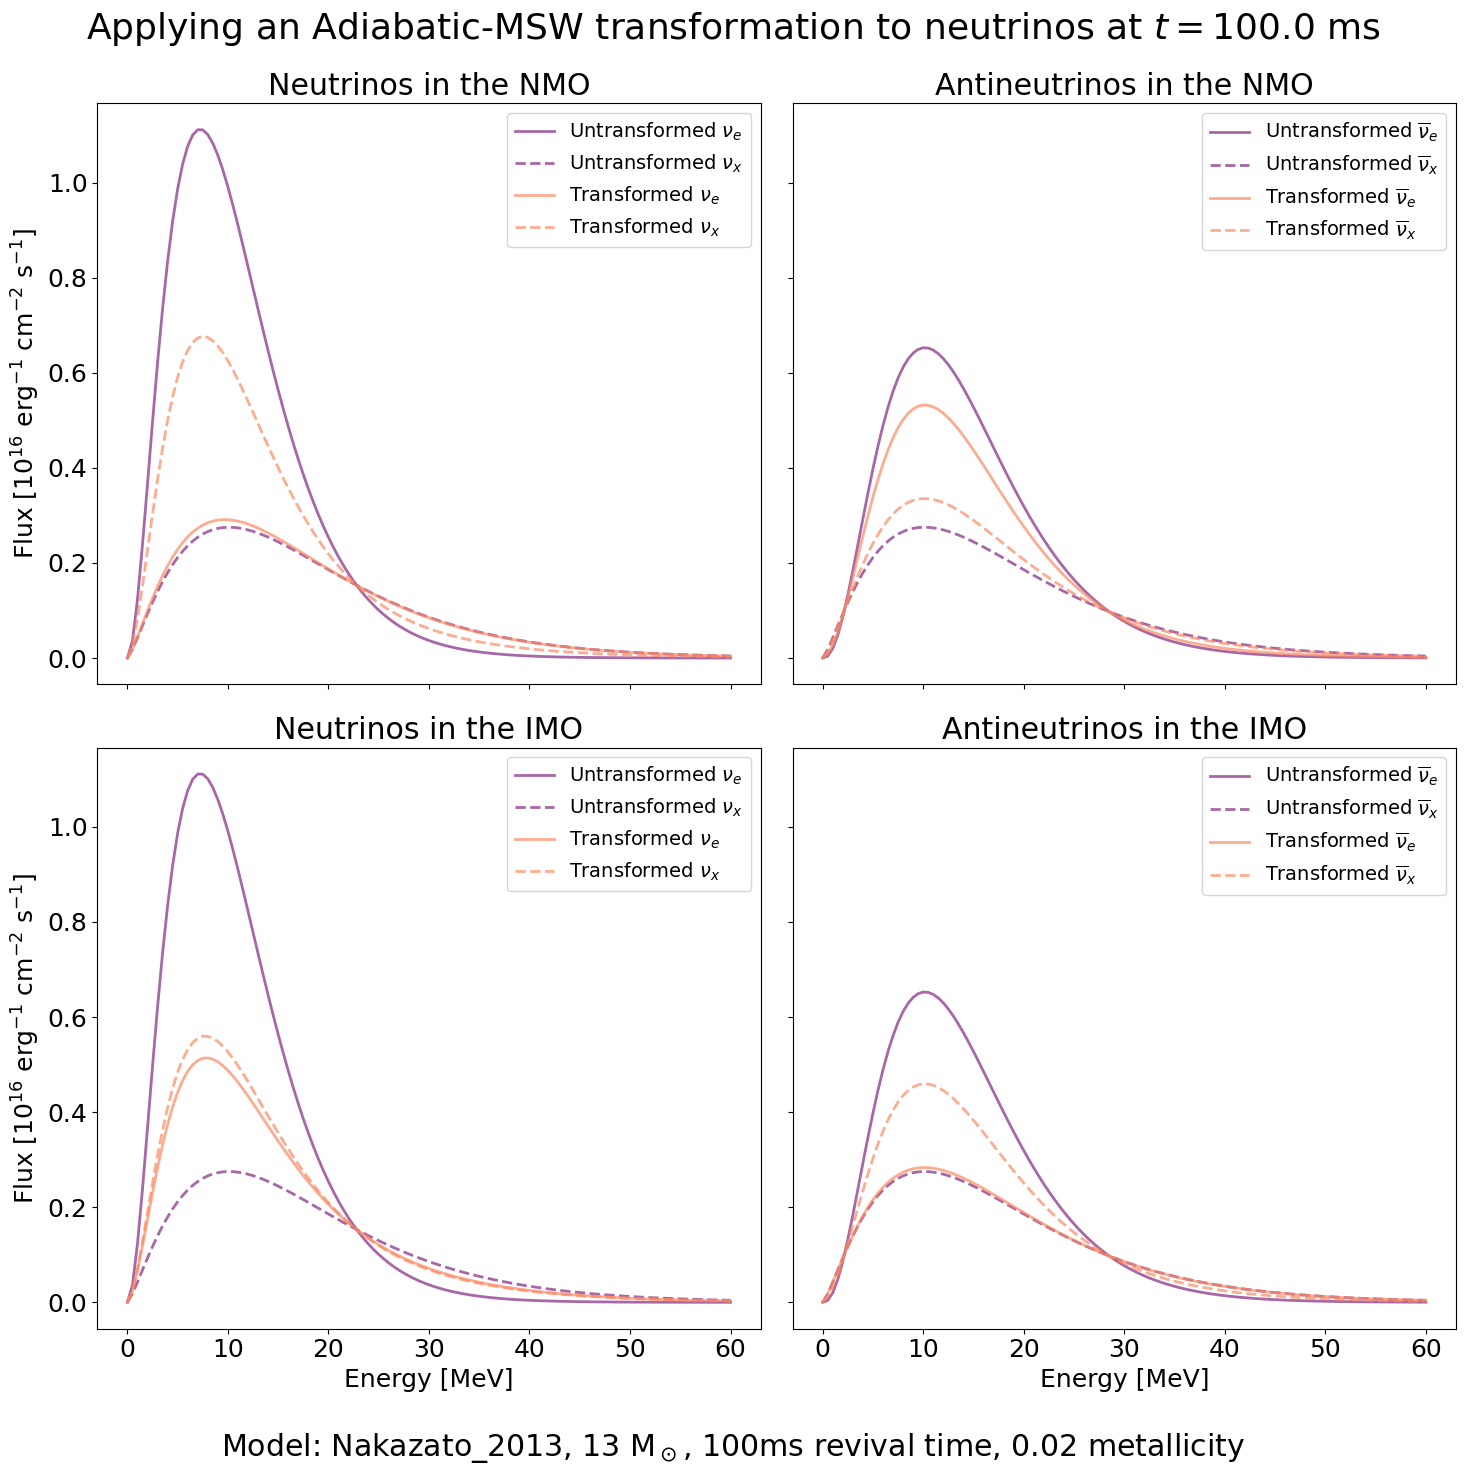

In [15]:
# define supernova model
model = Nakazato_2013(progenitor_mass=13*u.solMass, revival_time=100*u.ms, metallicity=0.02, eos='shen')
#model = Bollig_2016(progenitor_mass=27*u.solMass)
#model = Zha_2021(progenitor_mass=16*u.solMass)


energies = np.linspace(0,60,121) * u.MeV
mass = 1 * u.eV

distance = 10 * u.kpc
arrival_time = 100 * u.ms

delayed_spectra, delayed_transformed_spectra_nmo, delayed_transformed_spectra_imo = get_delayed_flux(distance, arrival_time, energies, mass, model)
spectra, transformed_spectra_nmo, transformed_spectra_imo = get_flux(distance, arrival_time, energies, model)

X = np.linspace(0,1,9)
colors = []
for x in X:
    color = plt.cm.magma(x)
    colors += [color[:3]]

fig, axes = plt.subplots(2,2, figsize=(15,15), sharex=True, sharey=True, tight_layout=True)

for i, spec in enumerate([spectra, transformed_spectra_nmo]):
    axes[0][0].plot(energies, spec[Flavor.NU_E]/1e16, 
                label='Untransformed '+Flavor.NU_E.to_tex() if i==0 else 'Transformed '+Flavor.NU_E.to_tex(),
                color=colors[3] if i==0 else colors[6], ls='-', lw=2,  alpha=0.7)
    axes[0][0].plot(energies, spec[Flavor.NU_X]/1e16, 
                label='Untransformed '+Flavor.NU_X.to_tex() if i==0 else 'Transformed '+Flavor.NU_X.to_tex(),
                color=colors[3] if i==0 else colors[6], ls='--', lw=2,  alpha=0.7)
    
    axes[0][1].plot(energies, spec[Flavor.NU_E_BAR]/1e16, 
                label='Untransformed '+Flavor.NU_E_BAR.to_tex() if i==0 else 'Transformed '+Flavor.NU_E_BAR.to_tex(),
                color=colors[3] if i==0 else colors[6], ls='-', lw=2,  alpha=0.7)
    axes[0][1].plot(energies, spec[Flavor.NU_X_BAR]/1e16, 
                label='Untransformed '+Flavor.NU_X_BAR.to_tex() if i==0 else 'Transformed '+Flavor.NU_X_BAR.to_tex(),
                color=colors[3] if i==0 else colors[6], ls='--', lw=2,  alpha=0.7)

for i, spec in enumerate([spectra, transformed_spectra_imo]):
    axes[1][0].plot(energies, spec[Flavor.NU_E]/1e16, 
                label='Untransformed '+Flavor.NU_E.to_tex() if i==0 else 'Transformed '+Flavor.NU_E.to_tex(),
                color=colors[3] if i==0 else colors[6], ls='-', lw=2,  alpha=0.7)
    axes[1][0].plot(energies, spec[Flavor.NU_X]/1e16, 
                label='Untransformed '+Flavor.NU_X.to_tex() if i==0 else 'Transformed '+Flavor.NU_X.to_tex(),
                color=colors[3] if i==0 else colors[6], ls='--', lw=2,  alpha=0.7)

    axes[1][1].plot(energies, spec[Flavor.NU_E_BAR]/1e16, 
                label='Untransformed '+Flavor.NU_E_BAR.to_tex() if i==0 else 'Transformed '+Flavor.NU_E_BAR.to_tex(),
                color=colors[3] if i==0 else colors[6], ls='-', lw=2,  alpha=0.7)
    axes[1][1].plot(energies, spec[Flavor.NU_X_BAR]/1e16, 
                label='Untransformed '+Flavor.NU_X_BAR.to_tex() if i==0 else 'Transformed '+Flavor.NU_X_BAR.to_tex(),
                color=colors[3] if i==0 else colors[6], ls='--', lw=2,  alpha=0.7)


axes[0][0].legend(loc='upper right', fontsize=14)
axes[0][1].legend(loc='upper right', fontsize=14)
axes[1][0].legend(loc='upper right', fontsize=14)
axes[1][1].legend(loc='upper right', fontsize=14)

fig.suptitle('Applying an Adiabatic-MSW transformation to neutrinos at $t = ${:.1f}'.format(arrival_time), fontsize=26)
fig.supxlabel("Model: Nakazato_2013, 13 M$_\odot$, 100ms revival time, 0.02 metallicity")

axes[0][0].set(title='Neutrinos in the NMO')
axes[0][1].set(title='Antineutrinos in the NMO')
axes[1][0].set(title='Neutrinos in the IMO')
axes[1][1].set(title='Antineutrinos in the IMO')

axes[0][0].set(ylabel=r'Flux [$10^{16}$ erg$^{-1}$ cm$^{-2}$ s$^{-1}$]')
axes[1][0].set(xlabel = r'Energy [MeV]', ylabel=r'Flux [$10^{16}$ erg$^{-1}$ cm$^{-2}$ s$^{-1}$]')
axes[1][1].set(xlabel = r'Energy [MeV]')

#fig.savefig('applying transform.png')

#could focus on just one flavour? make decision 


[Text(0.5, 0, 'Energy [MeV]')]

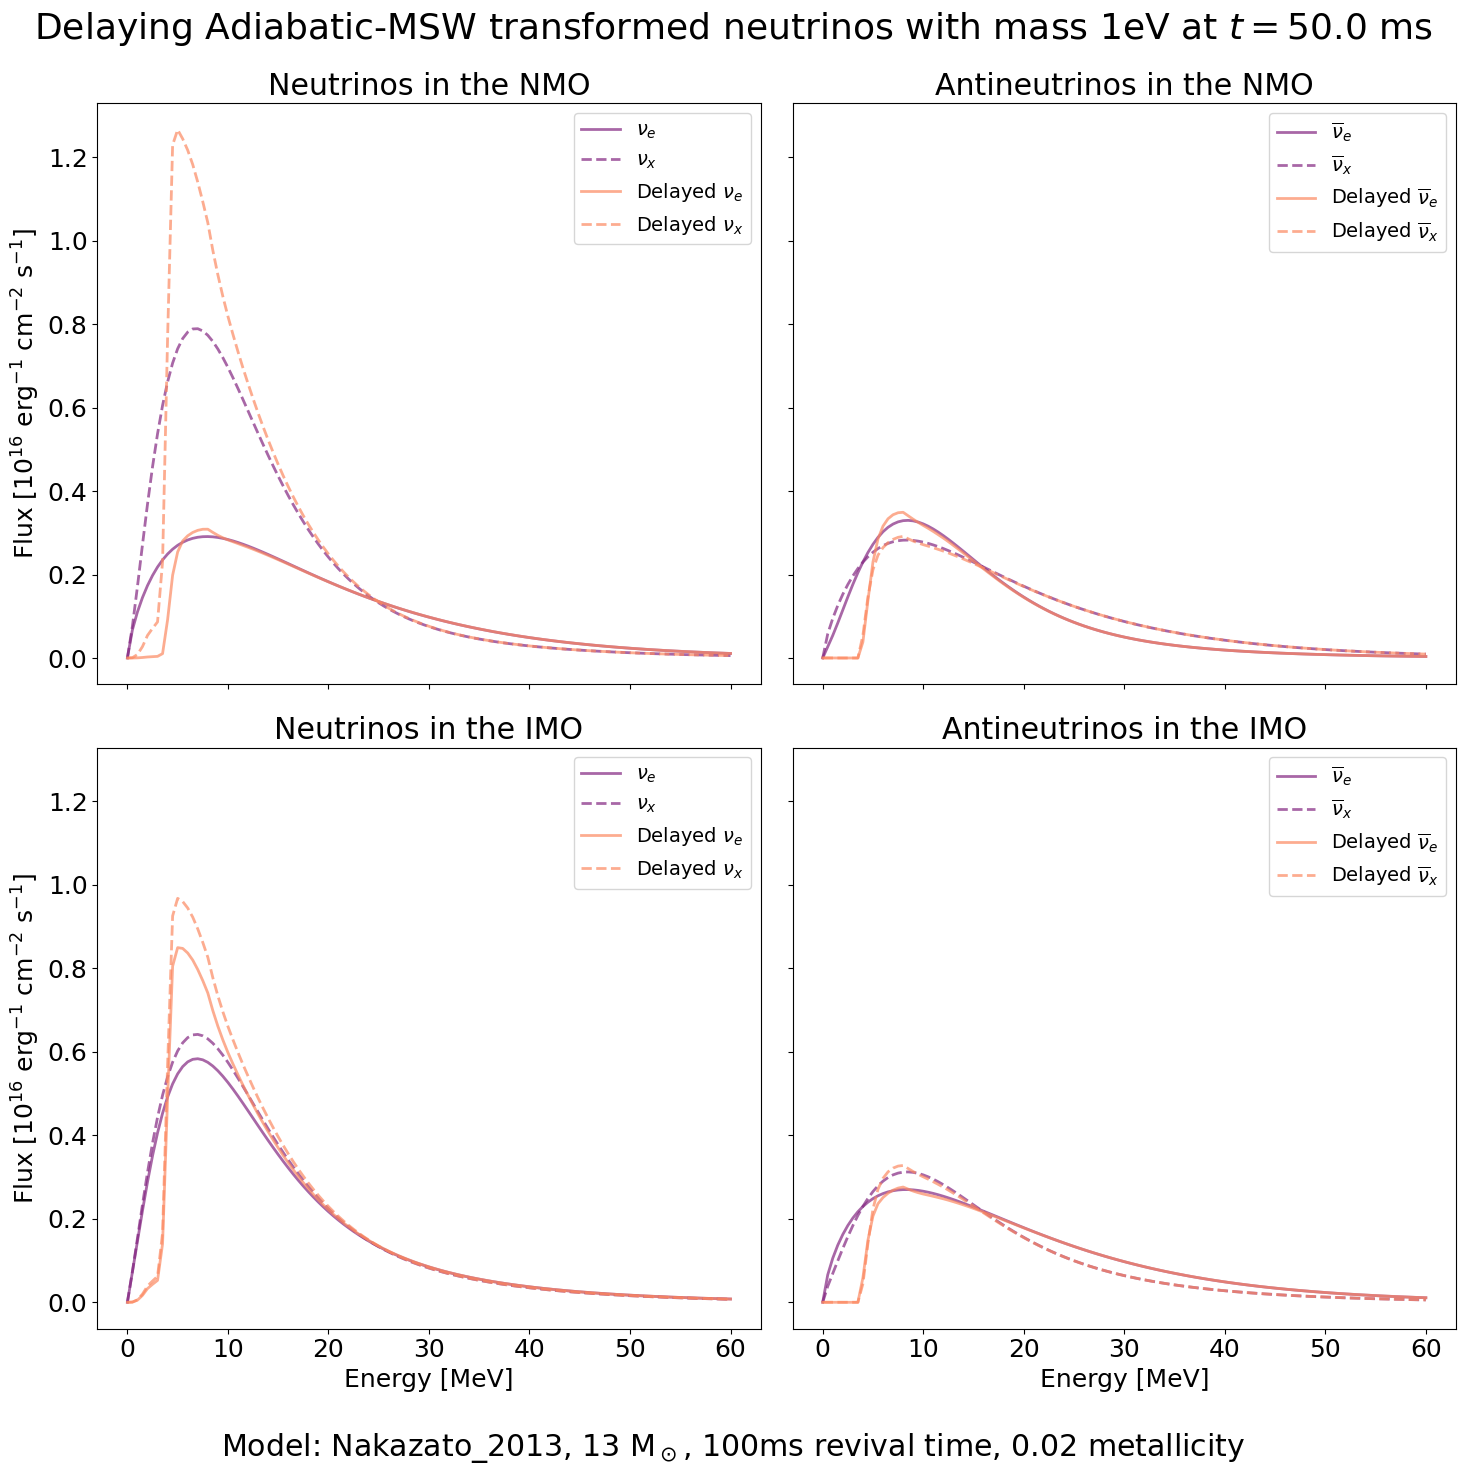

In [17]:
# define supernova model
model = Nakazato_2013(progenitor_mass=13*u.solMass, revival_time=100*u.ms, metallicity=0.02, eos='shen')
#model = Bollig_2016(progenitor_mass=27*u.solMass)
#model = Zha_2021(progenitor_mass=16*u.solMass)


energies = np.linspace(0,60,121) * u.MeV
mass = 1 * u.eV

distance = 10 * u.kpc
arrival_time = 50 * u.ms

delayed_spectra, delayed_transformed_spectra_nmo, delayed_transformed_spectra_imo = get_delayed_flux(distance, arrival_time, energies, mass, model)
spectra, transformed_spectra_nmo, transformed_spectra_imo = get_flux(distance, arrival_time, energies, model)

X = np.linspace(0,1,9)
colors = []
for x in X:
    color = plt.cm.magma(x)
    colors += [color[:3]]

fig, axes = plt.subplots(2,2, figsize=(15,15), sharex=True, sharey=True, tight_layout=True)

for i, spec in enumerate([spectra, transformed_spectra_nmo]):
    if i == 1:
        axes[0][0].plot(energies, spec[Flavor.NU_E]/1e16, 
                    label=Flavor.NU_E.to_tex(),
                    color=colors[3], ls='-', lw=2,  alpha=0.7)
        axes[0][0].plot(energies, spec[Flavor.NU_X]/1e16, 
                    label=Flavor.NU_X.to_tex(),
                    color=colors[3], ls='--', lw=2,  alpha=0.7)

        axes[0][1].plot(energies, spec[Flavor.NU_E_BAR]/1e16, 
                    label=Flavor.NU_E_BAR.to_tex(),
                    color=colors[3], ls='-', lw=2,  alpha=0.7)
        axes[0][1].plot(energies, spec[Flavor.NU_X_BAR]/1e16, 
                    label=Flavor.NU_X_BAR.to_tex(),
                    color=colors[3], ls='--', lw=2,  alpha=0.7)

for i, spec in enumerate([spectra, transformed_spectra_imo]):
    if i == 1:  
        axes[1][0].plot(energies, spec[Flavor.NU_E]/1e16, 
                    label=Flavor.NU_E.to_tex(),
                    color=colors[3], ls='-', lw=2,  alpha=0.7)
        axes[1][0].plot(energies, spec[Flavor.NU_X]/1e16, 
                    label=Flavor.NU_X.to_tex(),
                    color=colors[3], ls='--', lw=2,  alpha=0.7)

        axes[1][1].plot(energies, spec[Flavor.NU_E_BAR]/1e16, 
                    label=Flavor.NU_E_BAR.to_tex(),
                    color=colors[3], ls='-', lw=2,  alpha=0.7)
        axes[1][1].plot(energies, spec[Flavor.NU_X_BAR]/1e16, 
                    label=Flavor.NU_X_BAR.to_tex(),
                    color=colors[3], ls='--', lw=2,  alpha=0.7)

for i, spec in enumerate([delayed_spectra, delayed_transformed_spectra_nmo]):
    if i == 1:
        axes[0][0].plot(energies, spec[Flavor.NU_E]/1e16, 
                    label='Delayed '+Flavor.NU_E.to_tex(),
                    color=colors[6], ls='-', lw=2,  alpha=0.7)
        axes[0][0].plot(energies, spec[Flavor.NU_X]/1e16, 
                    label='Delayed '+Flavor.NU_X.to_tex(),
                    color=colors[6], ls='--', lw=2,  alpha=0.7)

        axes[0][1].plot(energies, spec[Flavor.NU_E_BAR]/1e16, 
                    label='Delayed '+Flavor.NU_E_BAR.to_tex(),
                    color=colors[6], ls='-', lw=2,  alpha=0.7)
        axes[0][1].plot(energies, spec[Flavor.NU_X_BAR]/1e16, 
                    label='Delayed '+Flavor.NU_X_BAR.to_tex(),
                    color=colors[6], ls='--', lw=2,  alpha=0.7)   

for i, spec in enumerate([delayed_spectra, delayed_transformed_spectra_imo]):
    if i == 1:
        axes[1][0].plot(energies, spec[Flavor.NU_E]/1e16, 
                    label='Delayed '+Flavor.NU_E.to_tex(),
                    color=colors[6], ls='-', lw=2,  alpha=0.7)
        axes[1][0].plot(energies, spec[Flavor.NU_X]/1e16, 
                    label='Delayed '+Flavor.NU_X.to_tex(),
                    color=colors[6], ls='--', lw=2,  alpha=0.7)

        axes[1][1].plot(energies, spec[Flavor.NU_E_BAR]/1e16, 
                    label='Delayed '+Flavor.NU_E_BAR.to_tex(),
                    color=colors[6], ls='-', lw=2,  alpha=0.7)
        axes[1][1].plot(energies, spec[Flavor.NU_X_BAR]/1e16, 
                    label='Delayed '+Flavor.NU_X_BAR.to_tex(),
                    color=colors[6], ls='--', lw=2,  alpha=0.7)

axes[0][0].legend(loc='upper right', fontsize=14)
axes[0][1].legend(loc='upper right', fontsize=14)
axes[1][0].legend(loc='upper right', fontsize=14)
axes[1][1].legend(loc='upper right', fontsize=14)

fig.suptitle('Delaying Adiabatic-MSW transformed neutrinos with mass 1eV at $t = ${:.1f}'.format(arrival_time), fontsize=26)
fig.supxlabel("Model: Nakazato_2013, 13 M$_\odot$, 100ms revival time, 0.02 metallicity")

axes[0][0].set(title='Neutrinos in the NMO')
axes[0][1].set(title='Antineutrinos in the NMO')
axes[1][0].set(title='Neutrinos in the IMO')
axes[1][1].set(title='Antineutrinos in the IMO')

axes[0][0].set(ylabel=r'Flux [$10^{16}$ erg$^{-1}$ cm$^{-2}$ s$^{-1}$]')
axes[1][0].set(xlabel = r'Energy [MeV]', ylabel=r'Flux [$10^{16}$ erg$^{-1}$ cm$^{-2}$ s$^{-1}$]')
axes[1][1].set(xlabel = r'Energy [MeV]')

#fig.savefig('delay_vs_undelayed.png')

# notes: probably should leave out untransformed - doesnt really give valuable info
#could focus on just one flavour? make decision 
# should seperate effect of transform and effect of adding delay for clarity

#mess around w the 

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ] eV


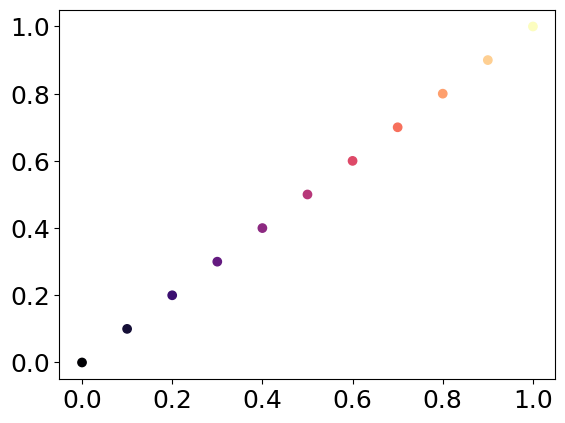

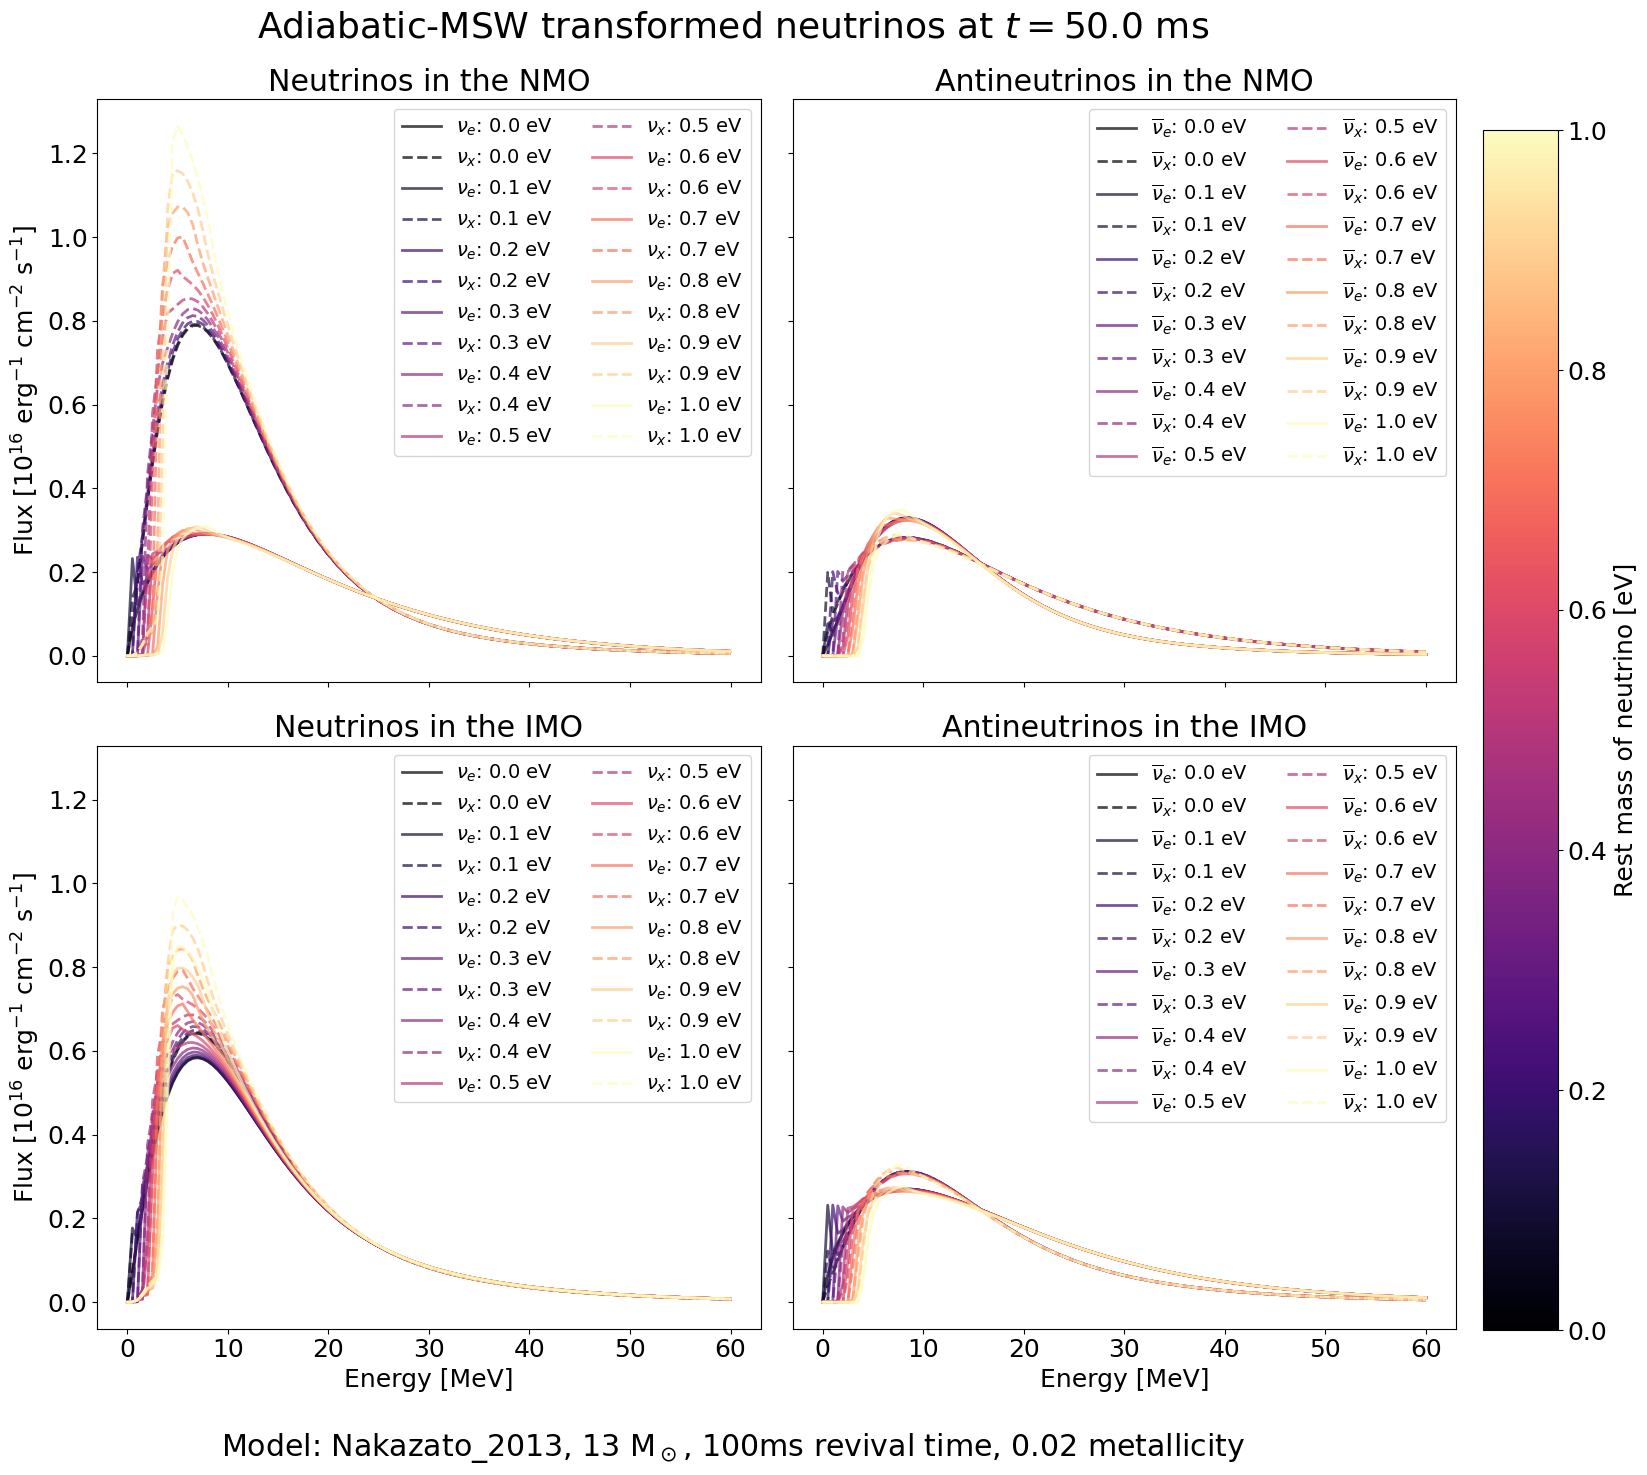

In [622]:
#zooming in on 0-1 eV range TRANSFORMED

model = Nakazato_2013(progenitor_mass=13*u.solMass, revival_time=100*u.ms, metallicity=0.02, eos='shen')
masses = np.linspace(0,1,11)  * u.eV
print(masses)

distance= 10 * u.kpc
arrival_time = 50 * u.ms

X = np.linspace(0,1,len(masses))
colors = []
for x in X:
    color = plt.cm.magma(x)
    colors += [color[:3]]

im = plt.scatter(X, X, c = masses, cmap = 'magma') #throwaway plot just to get colorbar

fig, axes = plt.subplots(2,2, figsize=(15,15), sharex=True, sharey=True, tight_layout=True)

for j in range(len(masses)):

    delayed_spectra, delayed_transformed_spectra_nmo, delayed_transformed_spectra_imo = get_delayed_flux(distance, arrival_time, energies, masses[j], model)
    
    for i, spec in enumerate([delayed_spectra, delayed_transformed_spectra_nmo]):
        if i == 1:
            axes[0][0].plot(energies, spec[Flavor.NU_E]/1e16, 
                    label=Flavor.NU_E.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='-', lw=2,  alpha=0.7)
            axes[0][0].plot(energies, spec[Flavor.NU_X]/1e16, 
                    label=Flavor.NU_X.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='--', lw=2,  alpha=0.7)
            axes[0][1].plot(energies, spec[Flavor.NU_E_BAR]/1e16, 
                    label=Flavor.NU_E_BAR.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='-', lw=2,  alpha=0.7)
            axes[0][1].plot(energies, spec[Flavor.NU_X_BAR]/1e16, 
                    label=Flavor.NU_X_BAR.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='--', lw=2,  alpha=0.7)
        else:
            pass
        
    for i, spec in enumerate([delayed_spectra, delayed_transformed_spectra_imo]):
        if i == 1:
            axes[1][0].plot(energies, spec[Flavor.NU_E]/1e16, 
                    label=Flavor.NU_E.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='-', lw=2,  alpha=0.7)
            axes[1][0].plot(energies, spec[Flavor.NU_X]/1e16, 
                    label=Flavor.NU_X.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='--', lw=2,  alpha=0.7)
            axes[1][1].plot(energies, spec[Flavor.NU_E_BAR]/1e16, 
                    label=Flavor.NU_E_BAR.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='-', lw=2,  alpha=0.7)
            axes[1][1].plot(energies, spec[Flavor.NU_X_BAR]/1e16, 
                    label=Flavor.NU_X_BAR.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='--', lw=2,  alpha=0.7)
        else:
            pass  

fig.suptitle('Adiabatic-MSW transformed neutrinos at $t = ${:.1f}'.format(arrival_time), fontsize=26)
fig.supxlabel("Model: Nakazato_2013, 13 M$_\odot$, 100ms revival time, 0.02 metallicity")

axes[0][0].set(title='Neutrinos in the NMO')
axes[0][1].set(title='Antineutrinos in the NMO')
axes[1][0].set(title='Neutrinos in the IMO')
axes[1][1].set(title='Antineutrinos in the IMO')

axes[0][0].legend(loc='upper right', ncol=2, fontsize=14)
axes[0][1].legend(loc='upper right', ncol=2, fontsize=14)

axes[1][0].legend(loc='upper right', ncol=2, fontsize=14)
axes[1][1].legend(loc='upper right', ncol=2, fontsize=14)

axes[0][0].set(ylabel=r'Flux [$10^{16}$ erg$^{-1}$ cm$^{-2}$ s$^{-1}$]')
axes[1][0].set(xlabel = r'Energy [MeV]', ylabel=r'Flux [$10^{16}$ erg$^{-1}$ cm$^{-2}$ s$^{-1}$]')
axes[1][1].set(xlabel = r'Energy [MeV]')

fig.subplots_adjust(right=1)
cbar_axes = fig.add_axes([1.0, 0.10, 0.05, 0.8])
fig.colorbar(im, cax=cbar_axes, label='Rest mass of neutrino [eV]')

#fig.savefig('low-mass_transformed.pdf')


#make this only go up to 1eV - to simplify

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.] eV


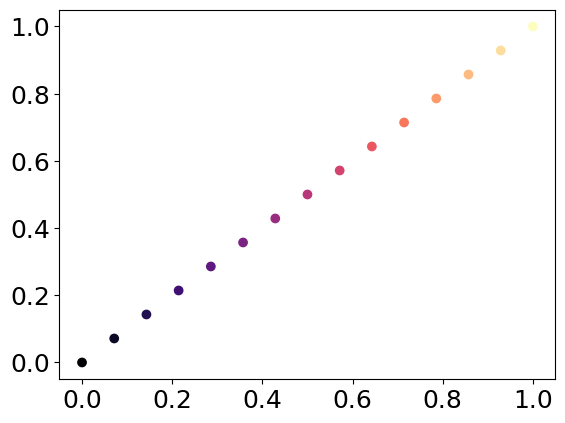

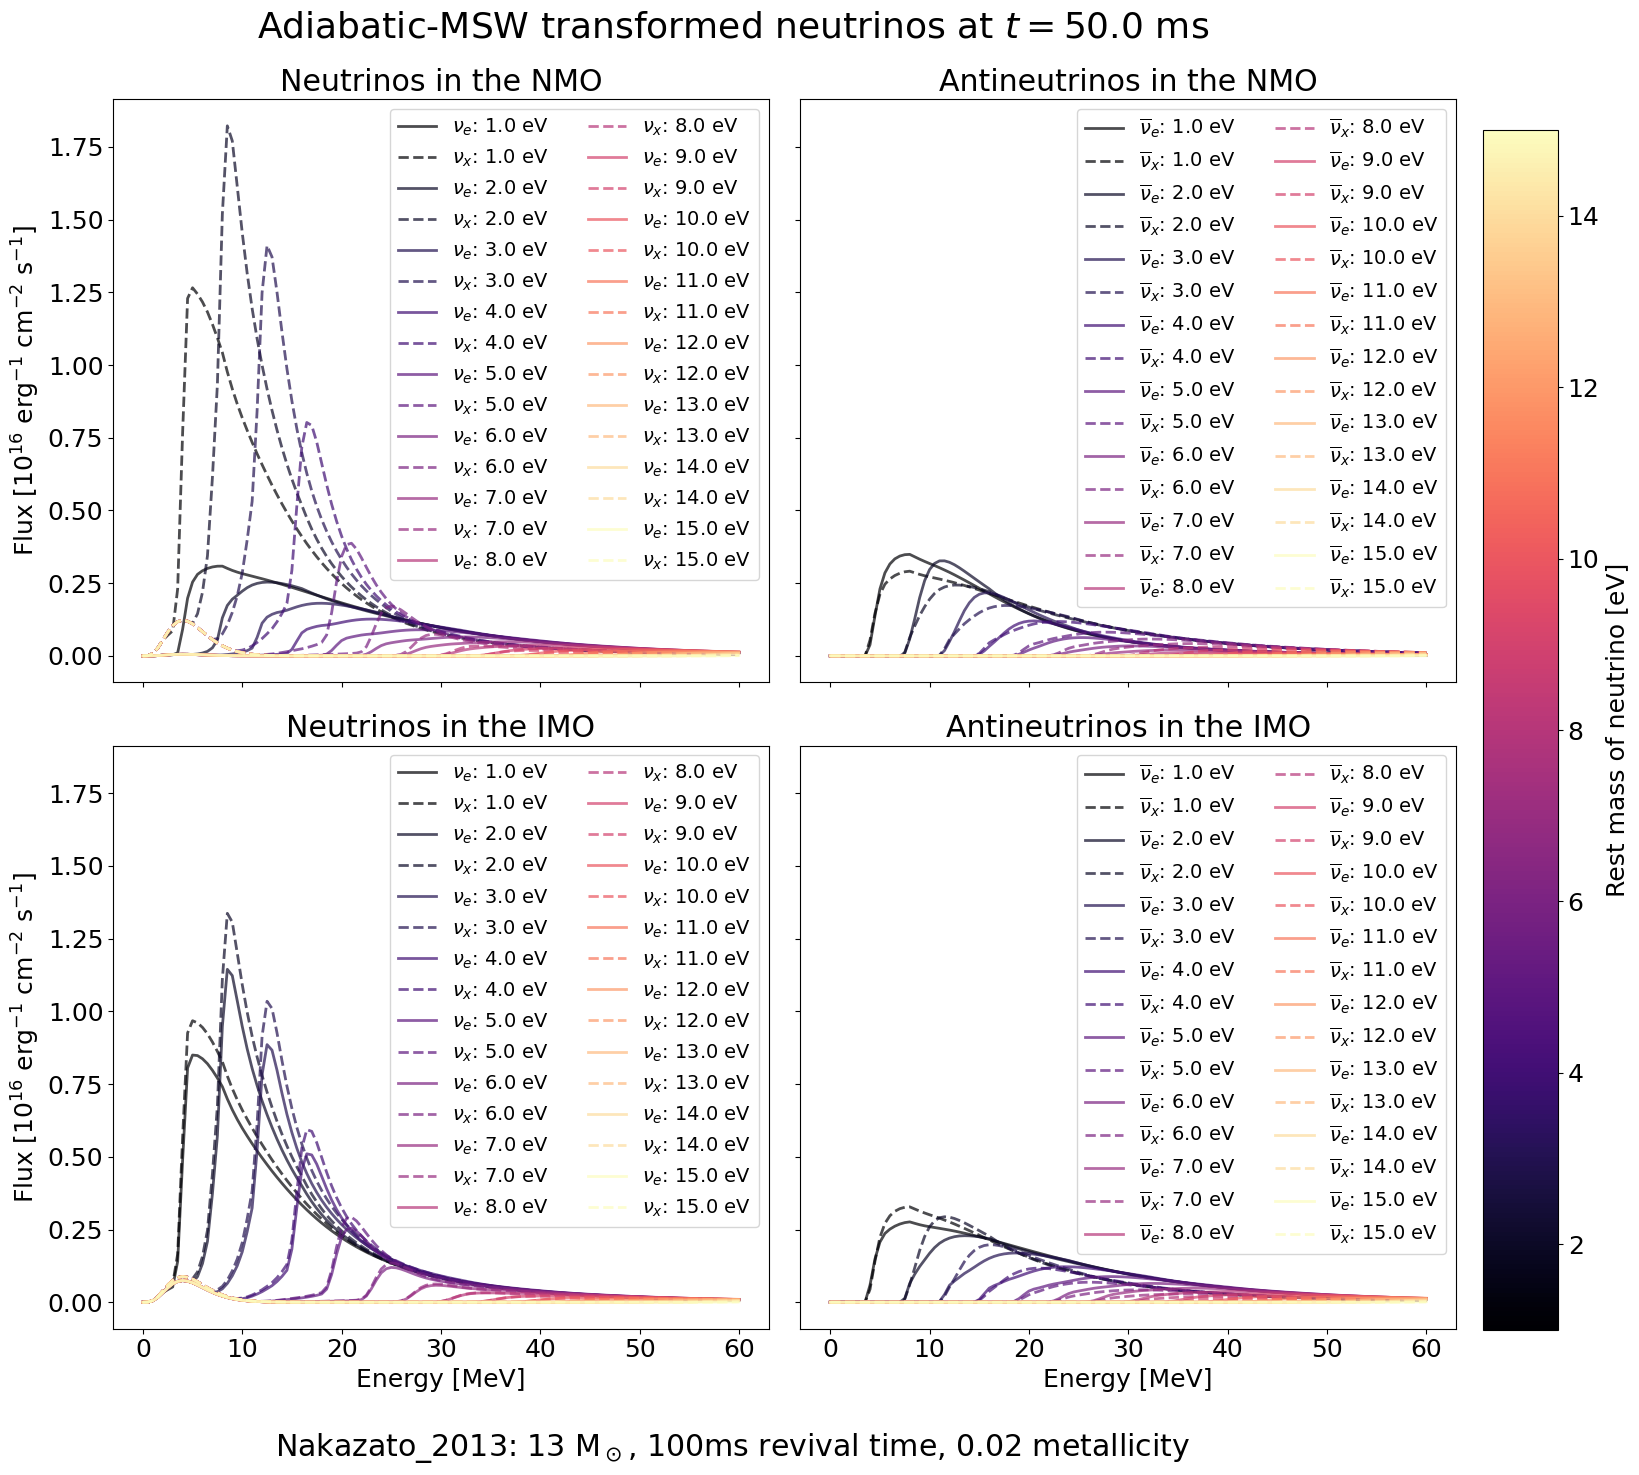

In [592]:
#zooming in on 1-15 eV range TRANSFORMED

model = Nakazato_2013(progenitor_mass=13*u.solMass, revival_time=100*u.ms, metallicity=0.02, eos='shen')
masses = np.logspace(0,2,15)  * u.eV
masses = np.linspace(1,15,15)  * u.eV

print(masses)

distance= 10 * u.kpc
arrival_time = 50 * u.ms

X = np.linspace(0,1,len(masses))
colors = []
for x in X:
    color = plt.cm.magma(x)
    colors += [color[:3]]

im = plt.scatter(X, X, c = masses, cmap = 'magma') #throwaway plot just to get colorbar

fig, axes = plt.subplots(2,2, figsize=(15,15), sharex=True, sharey=True, tight_layout=True)

for j in range(len(masses)):

    delayed_spectra, delayed_transformed_spectra_nmo, delayed_transformed_spectra_imo = get_delayed_flux(distance, arrival_time, energies, masses[j], model)
    
    for i, spec in enumerate([delayed_spectra, delayed_transformed_spectra_nmo]):
        if i == 1:
            axes[0][0].plot(energies, spec[Flavor.NU_E]/1e16, 
                    label=Flavor.NU_E.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='-', lw=2,  alpha=0.7)
            axes[0][0].plot(energies, spec[Flavor.NU_X]/1e16, 
                    label=Flavor.NU_X.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='--', lw=2,  alpha=0.7)
            axes[0][1].plot(energies, spec[Flavor.NU_E_BAR]/1e16, 
                    label=Flavor.NU_E_BAR.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='-', lw=2,  alpha=0.7)
            axes[0][1].plot(energies, spec[Flavor.NU_X_BAR]/1e16, 
                    label=Flavor.NU_X_BAR.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='--', lw=2,  alpha=0.7)
        else:
            pass
        
    for i, spec in enumerate([delayed_spectra, delayed_transformed_spectra_imo]):
        if i == 1:
            axes[1][0].plot(energies, spec[Flavor.NU_E]/1e16, 
                    label=Flavor.NU_E.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='-', lw=2,  alpha=0.7)
            axes[1][0].plot(energies, spec[Flavor.NU_X]/1e16, 
                    label=Flavor.NU_X.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='--', lw=2,  alpha=0.7)
            axes[1][1].plot(energies, spec[Flavor.NU_E_BAR]/1e16, 
                    label=Flavor.NU_E_BAR.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='-', lw=2,  alpha=0.7)
            axes[1][1].plot(energies, spec[Flavor.NU_X_BAR]/1e16, 
                    label=Flavor.NU_X_BAR.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='--', lw=2,  alpha=0.7)
        else:
            pass  

fig.suptitle('Adiabatic-MSW transformed neutrinos at $t = ${:.1f}'.format(arrival_time), fontsize=26)
fig.supxlabel("Model: Nakazato_2013, 13 M$_\odot$, 100ms revival time, 0.02 metallicity")

axes[0][0].set(title='Neutrinos in the NMO')
axes[0][1].set(title='Antineutrinos in the NMO')
axes[1][0].set(title='Neutrinos in the IMO')
axes[1][1].set(title='Antineutrinos in the IMO')

axes[0][0].legend(loc='upper right', ncol=2, fontsize=14)
axes[0][1].legend(loc='upper right', ncol=2, fontsize=14)

axes[1][0].legend(loc='upper right', ncol=2, fontsize=14)
axes[1][1].legend(loc='upper right', ncol=2, fontsize=14)

axes[0][0].set(ylabel=r'Flux [$10^{16}$ erg$^{-1}$ cm$^{-2}$ s$^{-1}$]')
axes[1][0].set(xlabel = r'Energy [MeV]', ylabel=r'Flux [$10^{16}$ erg$^{-1}$ cm$^{-2}$ s$^{-1}$]')
axes[1][1].set(xlabel = r'Energy [MeV]')

fig.subplots_adjust(right=1)
cbar_axes = fig.add_axes([1.0, 0.10, 0.05, 0.8])
cbar = fig.colorbar(im, cax=cbar_axes)
cbar.set_label('Rest mass of neutrino [eV]')


#try and plot this at a later time - see if the antinetrinos appear! it might just be because of the early time - verify this

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] eV


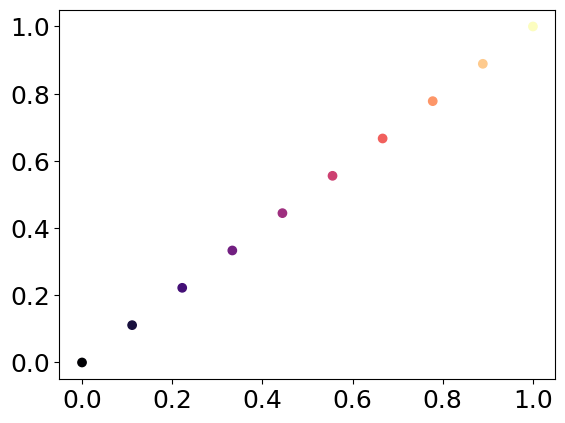

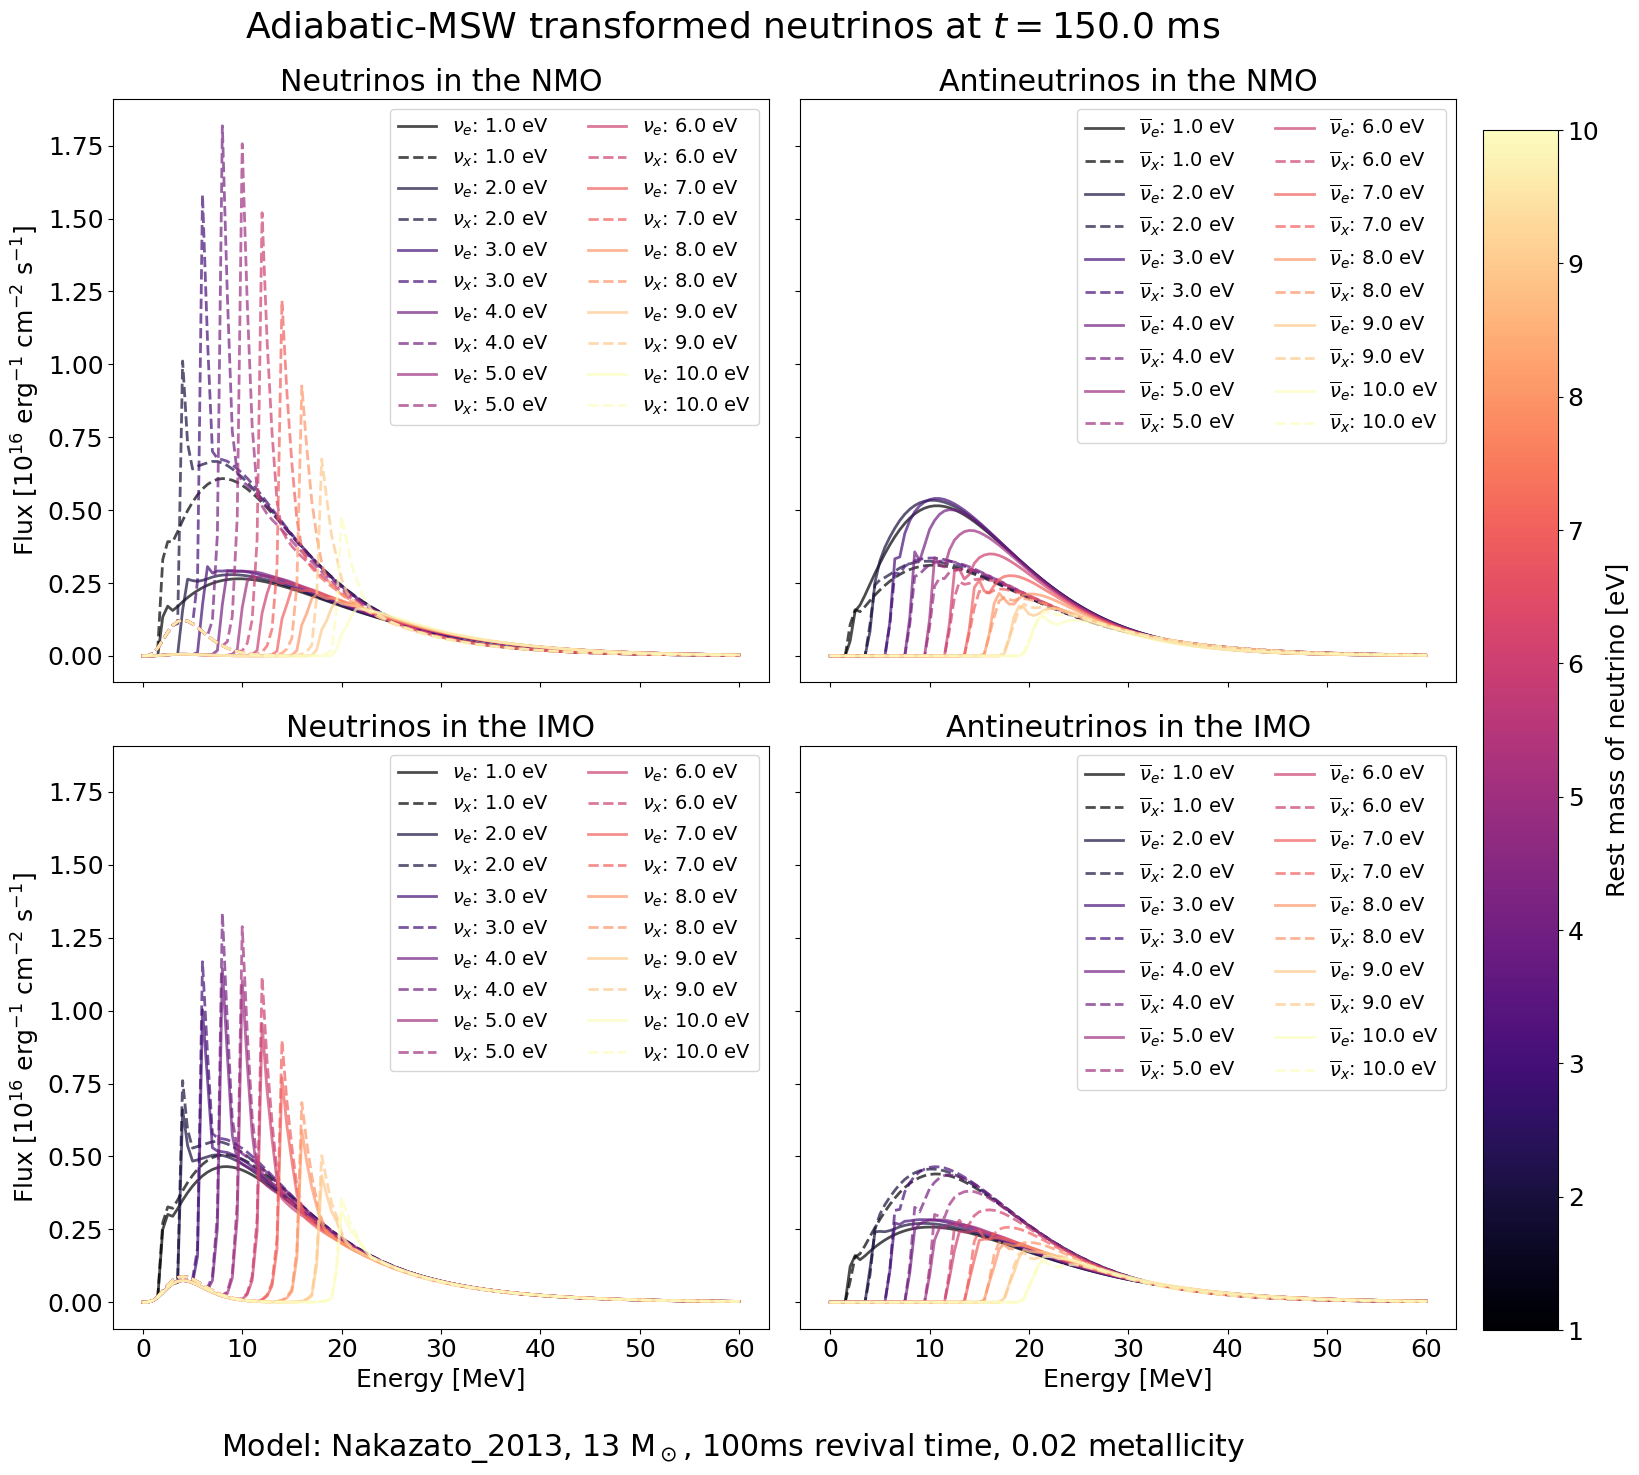

In [620]:
#zooming in on 1-15 eV range TRANSFORMED

model = Nakazato_2013(progenitor_mass=13*u.solMass, revival_time=100*u.ms, metallicity=0.02, eos='shen')
masses = np.logspace(0,2,15)  * u.eV
masses = np.linspace(1,10,10)  * u.eV

print(masses)

distance= 10 * u.kpc
arrival_time = 150 * u.ms

X = np.linspace(0,1,len(masses))
colors = []
for x in X:
    color = plt.cm.magma(x)
    colors += [color[:3]]

im = plt.scatter(X, X, c = masses, cmap = 'magma') #throwaway plot just to get colorbar

fig, axes = plt.subplots(2,2, figsize=(15,15), sharex=True, sharey=True, tight_layout=True)

for j in range(len(masses)):

    delayed_spectra, delayed_transformed_spectra_nmo, delayed_transformed_spectra_imo = get_delayed_flux(distance, arrival_time, energies, masses[j], model)
    
    for i, spec in enumerate([delayed_spectra, delayed_transformed_spectra_nmo]):
        if i == 1:
            axes[0][0].plot(energies, spec[Flavor.NU_E]/1e16, 
                    label=Flavor.NU_E.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='-', lw=2,  alpha=0.7)
            axes[0][0].plot(energies, spec[Flavor.NU_X]/1e16, 
                    label=Flavor.NU_X.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='--', lw=2,  alpha=0.7)
            axes[0][1].plot(energies, spec[Flavor.NU_E_BAR]/1e16, 
                    label=Flavor.NU_E_BAR.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='-', lw=2,  alpha=0.7)
            axes[0][1].plot(energies, spec[Flavor.NU_X_BAR]/1e16, 
                    label=Flavor.NU_X_BAR.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='--', lw=2,  alpha=0.7)
        else:
            pass
        
    for i, spec in enumerate([delayed_spectra, delayed_transformed_spectra_imo]):
        if i == 1:
            axes[1][0].plot(energies, spec[Flavor.NU_E]/1e16, 
                    label=Flavor.NU_E.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='-', lw=2,  alpha=0.7)
            axes[1][0].plot(energies, spec[Flavor.NU_X]/1e16, 
                    label=Flavor.NU_X.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='--', lw=2,  alpha=0.7)
            axes[1][1].plot(energies, spec[Flavor.NU_E_BAR]/1e16, 
                    label=Flavor.NU_E_BAR.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='-', lw=2,  alpha=0.7)
            axes[1][1].plot(energies, spec[Flavor.NU_X_BAR]/1e16, 
                    label=Flavor.NU_X_BAR.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='--', lw=2,  alpha=0.7)
        else:
            pass  

fig.suptitle('Adiabatic-MSW transformed neutrinos at $t = ${:.1f}'.format(arrival_time), fontsize=26)
fig.supxlabel("Model: Nakazato_2013, 13 M$_\odot$, 100ms revival time, 0.02 metallicity")

axes[0][0].set(title='Neutrinos in the NMO')
axes[0][1].set(title='Antineutrinos in the NMO')
axes[1][0].set(title='Neutrinos in the IMO')
axes[1][1].set(title='Antineutrinos in the IMO')

axes[0][0].legend(loc='upper right', ncol=2, fontsize=14)
axes[0][1].legend(loc='upper right', ncol=2, fontsize=14)

axes[1][0].legend(loc='upper right', ncol=2, fontsize=14)
axes[1][1].legend(loc='upper right', ncol=2, fontsize=14)

axes[0][0].set(ylabel=r'Flux [$10^{16}$ erg$^{-1}$ cm$^{-2}$ s$^{-1}$]')
axes[1][0].set(xlabel = r'Energy [MeV]', ylabel=r'Flux [$10^{16}$ erg$^{-1}$ cm$^{-2}$ s$^{-1}$]')
axes[1][1].set(xlabel = r'Energy [MeV]')

fig.subplots_adjust(right=1)
cbar_axes = fig.add_axes([1.0, 0.10, 0.05, 0.8])
cbar = fig.colorbar(im, cax=cbar_axes)
cbar.set_label('Rest mass of neutrino [eV]')


#try and plot this at a later time - see if the antinetrinos appear! it might just be because of the early time - verify this

# SCRAPPED WORK - IGNORE THIS

[ 1.          1.29154967  1.66810054  2.15443469  2.7825594   3.59381366
  4.64158883  5.9948425   7.74263683 10.        ] eV


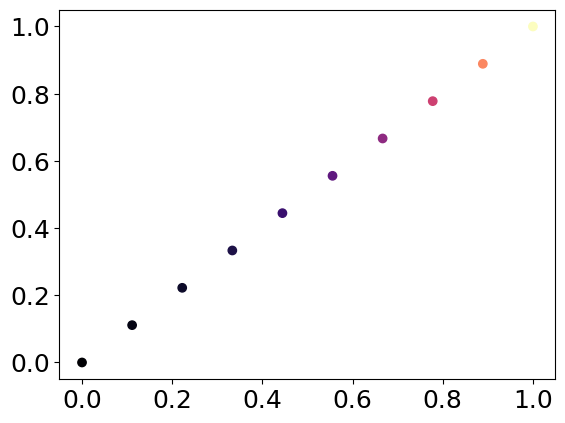

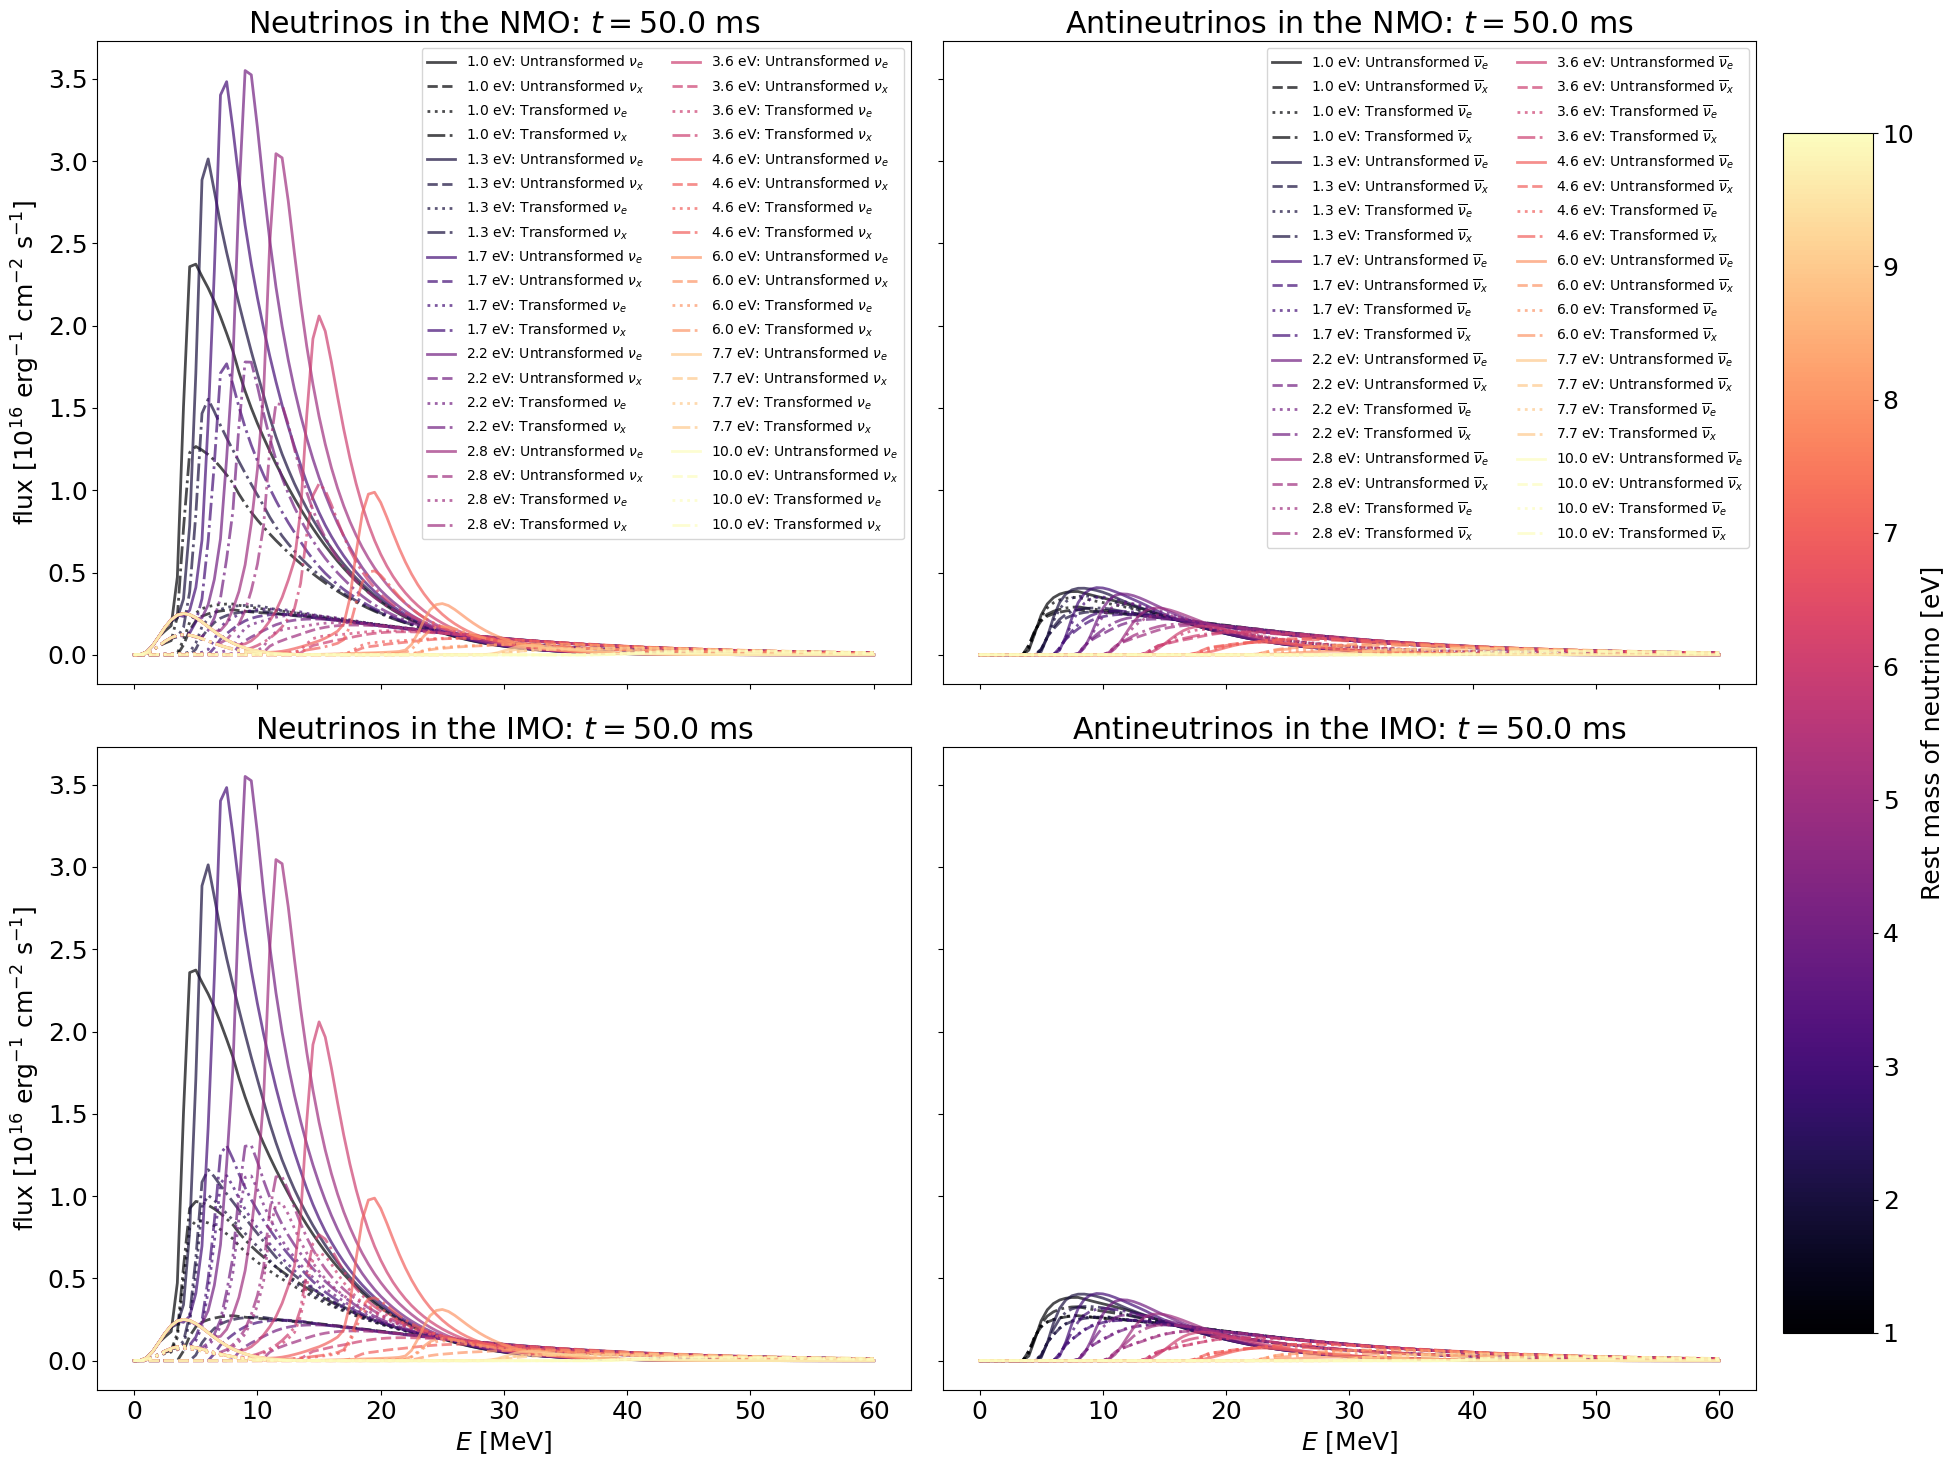

In [566]:
model = Nakazato_2013(progenitor_mass=13*u.solMass, revival_time=100*u.ms, metallicity=0.02, eos='shen')

energies = np.linspace(0,60,121) * u.MeV
masses = [0, 0.1, 0.5, 1, 2.5, 5, 7.5, 10, 15, 20, 25, 50, 100] * u.eV
masses = np.logspace(0,1,10) * u.eV
print(masses)

distance= 10 * u.kpc
arrival_time = 50 * u.ms

X = np.linspace(0,1,len(masses))
colors = []
for x in X:
    color = plt.cm.magma(x)
    colors += [color[:3]]
    
im = plt.scatter(X, X, c = masses, cmap = 'magma') #throwaway plot just to get colorbar


fig, axes = plt.subplots(2,2, figsize=(18,15), sharex=True, sharey=True, tight_layout=True)

for j in range(len(masses)):
    delayed_spectra, delayed_transformed_spectra_nmo, delayed_transformed_spectra_imo = get_delayed_flux(distance, arrival_time, energies, masses[j], model)
        
    for i, spec in enumerate([delayed_spectra, delayed_transformed_spectra_nmo]):
        axes[0][0].plot(energies, spec[Flavor.NU_E]/1e16, 
                    label=('{:.1f}: Untransformed '.format(masses[j])+Flavor.NU_E.to_tex()) if i==0 else '{:.1f}: Transformed '.format(masses[j])+Flavor.NU_E.to_tex(),
                    color=colors[j], ls='-' if i==0 else ':', lw=2,  alpha=0.7)
        axes[0][0].plot(energies, spec[Flavor.NU_X]/1e16, 
                    label='{:.1f}: Untransformed '.format(masses[j])+Flavor.NU_X.to_tex() if i==0 else '{:.1f}: Transformed '.format(masses[j])+Flavor.NU_X.to_tex(),
                    color=colors[j], ls='--' if i==0 else '-.', lw=2,  alpha=0.7)

        axes[0][1].plot(energies, spec[Flavor.NU_E_BAR]/1e16, 
                    label='{:.1f}: Untransformed '.format(masses[j])+Flavor.NU_E_BAR.to_tex() if i==0 else '{:.1f}: Transformed '.format(masses[j])+Flavor.NU_E_BAR.to_tex(),
                    color=colors[j], ls='-' if i==0 else ':', lw=2,  alpha=0.7)
        axes[0][1].plot(energies, spec[Flavor.NU_X_BAR]/1e16, 
                    label='{:.1f}: Untransformed '.format(masses[j])+Flavor.NU_X_BAR.to_tex() if i==0 else '{:.1f}: Transformed '.format(masses[j])+Flavor.NU_X_BAR.to_tex(),
                    color=colors[j], ls='--' if i==0 else '-.', lw=2,  alpha=0.7)   

    for i, spec in enumerate([delayed_spectra, delayed_transformed_spectra_imo]):    
        axes[1][0].plot(energies, spec[Flavor.NU_E]/1e16, 
                    label='{:.1f}: Untransformed '.format(masses[j])+Flavor.NU_E.to_tex() if i==0 else '{:.1f}: Transformed '.format(masses[j])+Flavor.NU_E.to_tex(),
                    color=colors[j], ls='-' if i==0 else ':', lw=2,  alpha=0.7)
        axes[1][0].plot(energies, spec[Flavor.NU_X]/1e16, 
                    label='{:.1f}: Untransformed '.format(masses[j])+Flavor.NU_X.to_tex() if i==0 else '{:.1f}: Transformed '.format(masses[j])+Flavor.NU_X.to_tex(),
                    color=colors[j], ls='--' if i==0 else '-.', lw=2,  alpha=0.7)

        axes[1][1].plot(energies, spec[Flavor.NU_E_BAR]/1e16, 
                    label='{:.1f}: Untransformed '.format(masses[j])+Flavor.NU_E_BAR.to_tex() if i==0 else '{:.1f}: Transformed '.format(masses[j])+Flavor.NU_E_BAR.to_tex(),
                    color=colors[j], ls='-' if i==0 else ':', lw=2,  alpha=0.7)
        axes[1][1].plot(energies, spec[Flavor.NU_X_BAR]/1e16, 
                    label='{:.1f}: Untransformed '.format(masses[j])+Flavor.NU_X_BAR.to_tex() if i==0 else '{:.1f}: Transformed '.format(masses[j])+Flavor.NU_X_BAR.to_tex(),
                    color=colors[j], ls='--' if i==0 else '-.', lw=2,  alpha=0.7)

axes[0][0].set(title='Neutrinos in the NMO: $t = ${:.1f}'.format(arrival_time))
axes[0][1].set(title='Antineutrinos in the NMO: $t = ${:.1f}'.format(arrival_time))     
axes[1][0].set(xlabel=r'$E$ [{}]'.format(energies.unit), title='Neutrinos in the IMO: $t = ${:.1f}'.format(arrival_time))
axes[1][1].set(xlabel=r'$E$ [{}]'.format(energies.unit), title='Antineutrinos in the IMO: $t = ${:.1f}'.format(arrival_time))
    
axes[0][0].legend(loc='upper right', ncol=2, fontsize=10)
axes[0][1].legend(loc='upper right', ncol=2, fontsize=10)
#axes[1][0].legend(loc='lower left', ncol=2, fontsize=16)
#axes[1][1].legend(loc='upper right', ncol=2, fontsize=16)

ax = axes[0][0]
ax.set(ylabel=r'flux [$10^{16}$ erg$^{-1}$ cm$^{-2}$ s$^{-1}$]')
ax = axes[1][0]
ax.set(ylabel=r'flux [$10^{16}$ erg$^{-1}$ cm$^{-2}$ s$^{-1}$]')

fig.subplots_adjust(right=1)
cbar_axes = fig.add_axes([1.0, 0.10, 0.05, 0.8])
cbar = fig.colorbar(im, cax=cbar_axes)
cbar.set_label('Rest mass of neutrino [eV]')


[  0.1          0.13335214   0.17782794   0.23713737   0.31622777
   0.4216965    0.56234133   0.74989421   1.           1.33352143
   1.77827941   2.37137371   3.16227766   4.21696503   5.62341325
   7.49894209  10.          13.33521432  17.7827941   23.71373706
  31.6227766   42.16965034  56.23413252  74.98942093 100.        ] eV


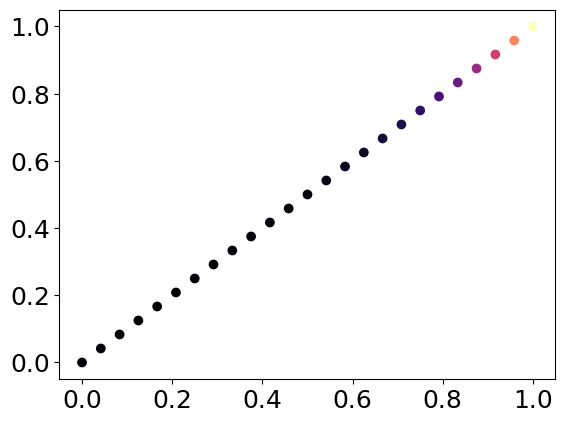

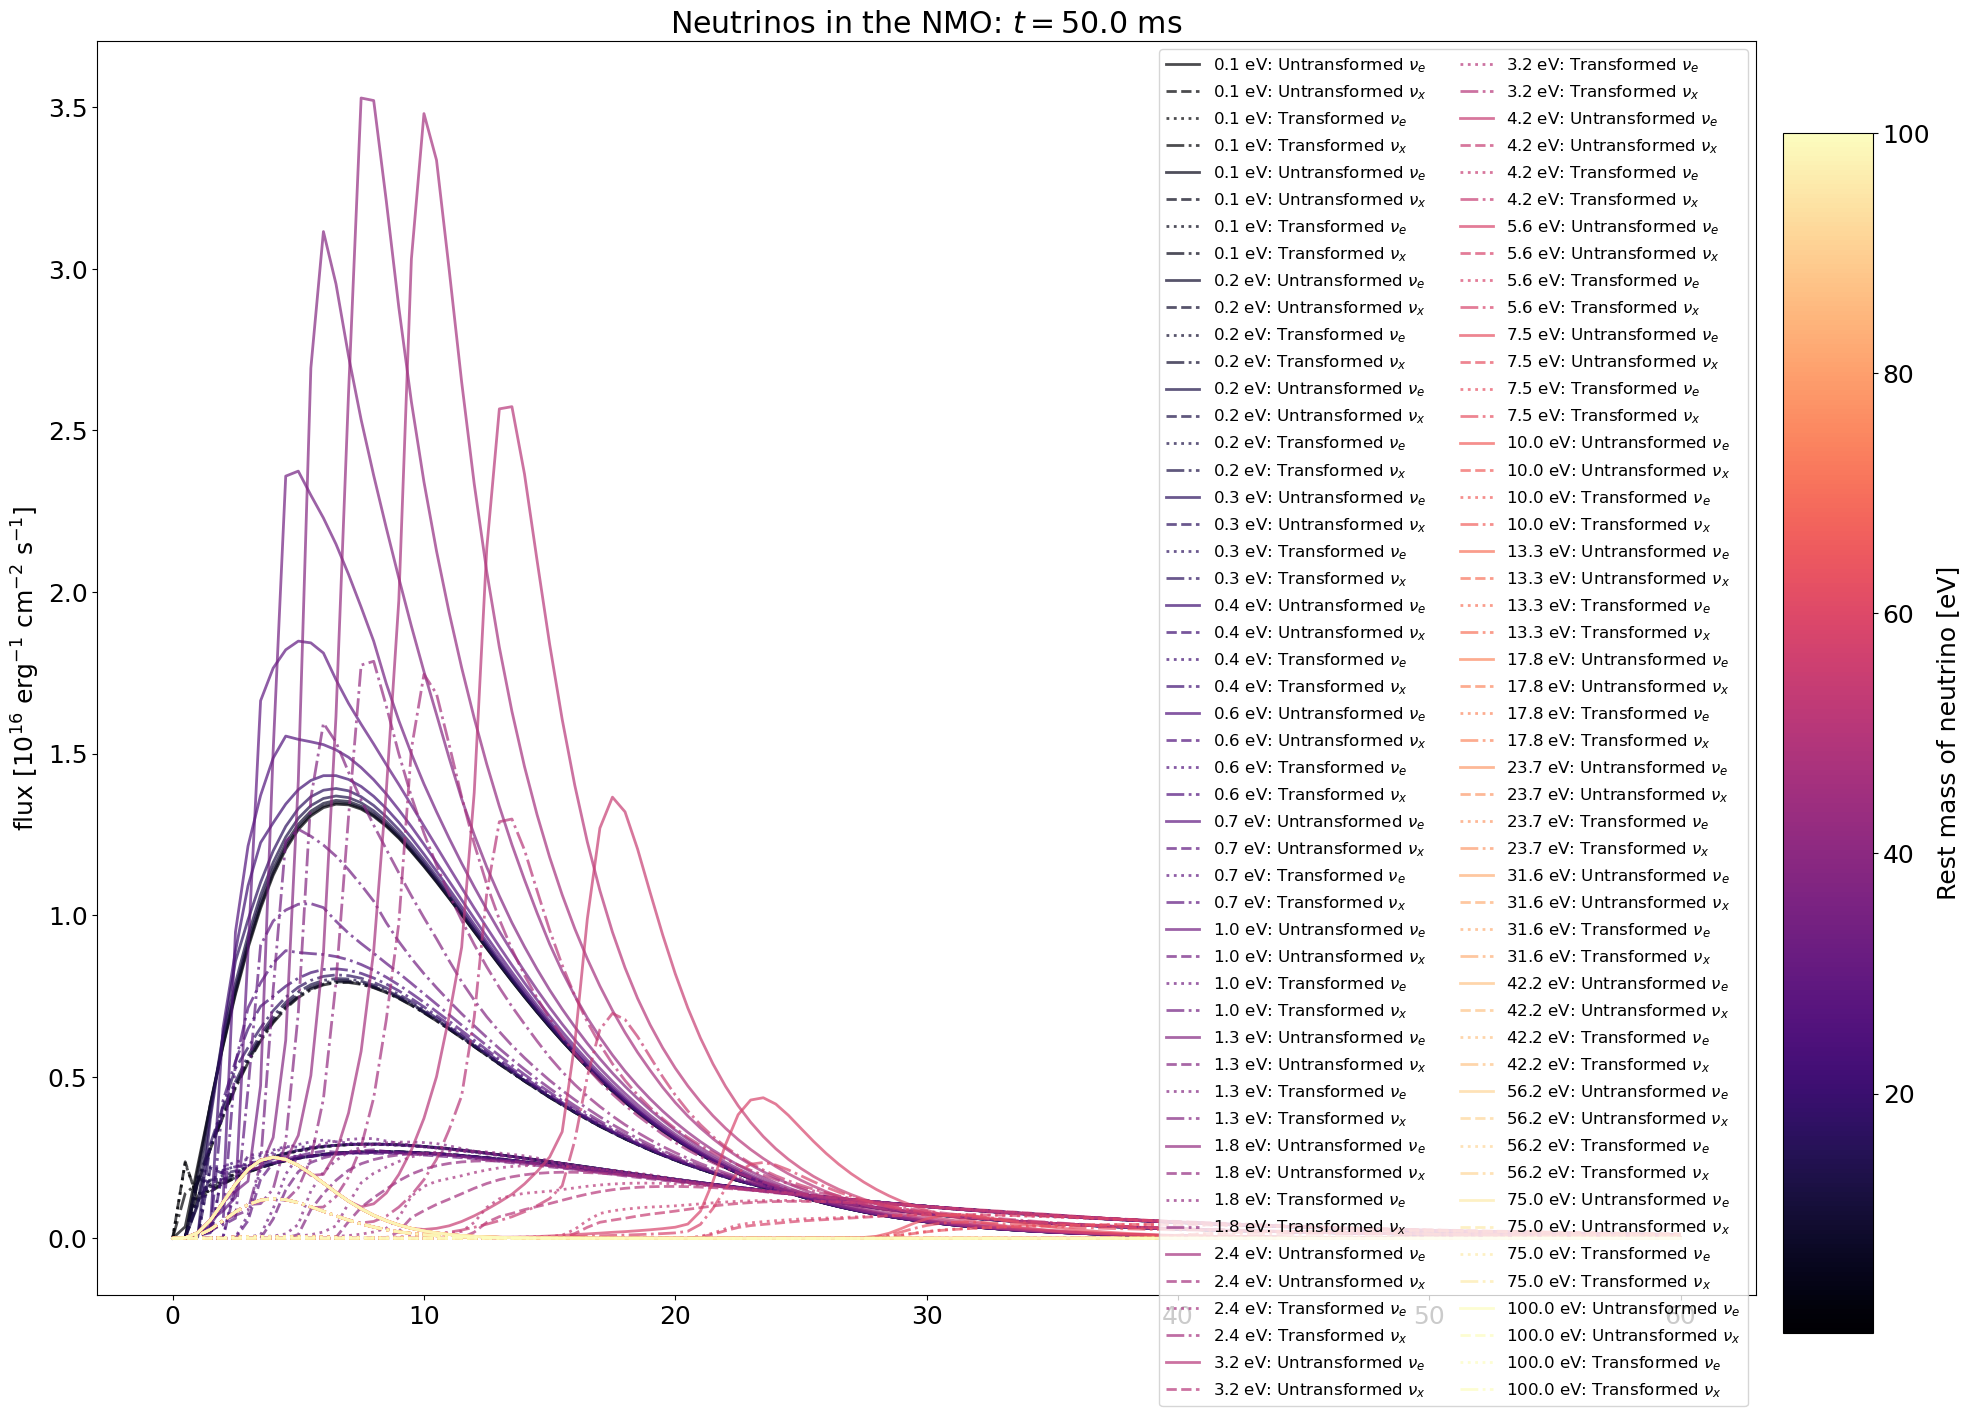

In [505]:
model = Nakazato_2013(progenitor_mass=13*u.solMass, revival_time=100*u.ms, metallicity=0.02, eos='shen')

energies = np.linspace(0,60,121) * u.MeV
masses = [0, 0.1, 0.5, 1, 2.5, 5, 7.5, 10, 15, 20, 25, 50, 100] * u.eV
masses = np.logspace(0,3,25)  / 10 * u.eV
print(masses)

distance= 10 * u.kpc
arrival_time = 50 * u.ms

X = np.linspace(0,1,len(masses))
colors = []
for x in X:
    color = plt.cm.magma(x)
    colors += [color[:3]]
    
im = plt.scatter(X, X, c = masses, cmap = 'magma') #throwaway plot just to get colorbar


fig, axes = plt.subplots(1,1, figsize=(18,15), sharex=True, sharey=True, tight_layout=True)


for j in range(len(masses)):

    delayed_spectra, delayed_transformed_spectra_nmo, delayed_transformed_spectra_imo = get_delayed_flux(distance, arrival_time, energies, masses[j], model)
        
    for i, spec in enumerate([delayed_spectra, delayed_transformed_spectra_nmo]):
        axes.plot(energies, spec[Flavor.NU_E]/1e16, 
                    label=('{:.1f}: Untransformed '.format(masses[j])+Flavor.NU_E.to_tex()) if i==0 else '{:.1f}: Transformed '.format(masses[j])+Flavor.NU_E.to_tex(),
                    color=colors[j], ls='-' if i==0 else ':', lw=2,  alpha=0.7)
        axes.plot(energies, spec[Flavor.NU_X]/1e16, 
                    label='{:.1f}: Untransformed '.format(masses[j])+Flavor.NU_X.to_tex() if i==0 else '{:.1f}: Transformed '.format(masses[j])+Flavor.NU_X.to_tex(),
                    color=colors[j], ls='--' if i==0 else '-.', lw=2,  alpha=0.7)

axes.set(title='Neutrinos in the NMO: $t = ${:.1f}'.format(arrival_time))

axes.legend(loc='upper right', ncol=2, fontsize=12)


axes.set(ylabel=r'flux [$10^{16}$ erg$^{-1}$ cm$^{-2}$ s$^{-1}$]')

fig.subplots_adjust(right=1)
cbar_axes = fig.add_axes([1.0, 0.10, 0.05, 0.8])
cbar = fig.colorbar(im, cax=cbar_axes)
cbar.set_label('Rest mass of neutrino [eV]')


[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ] eV


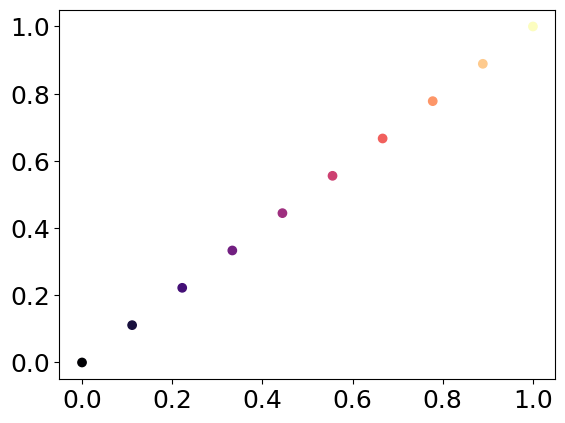

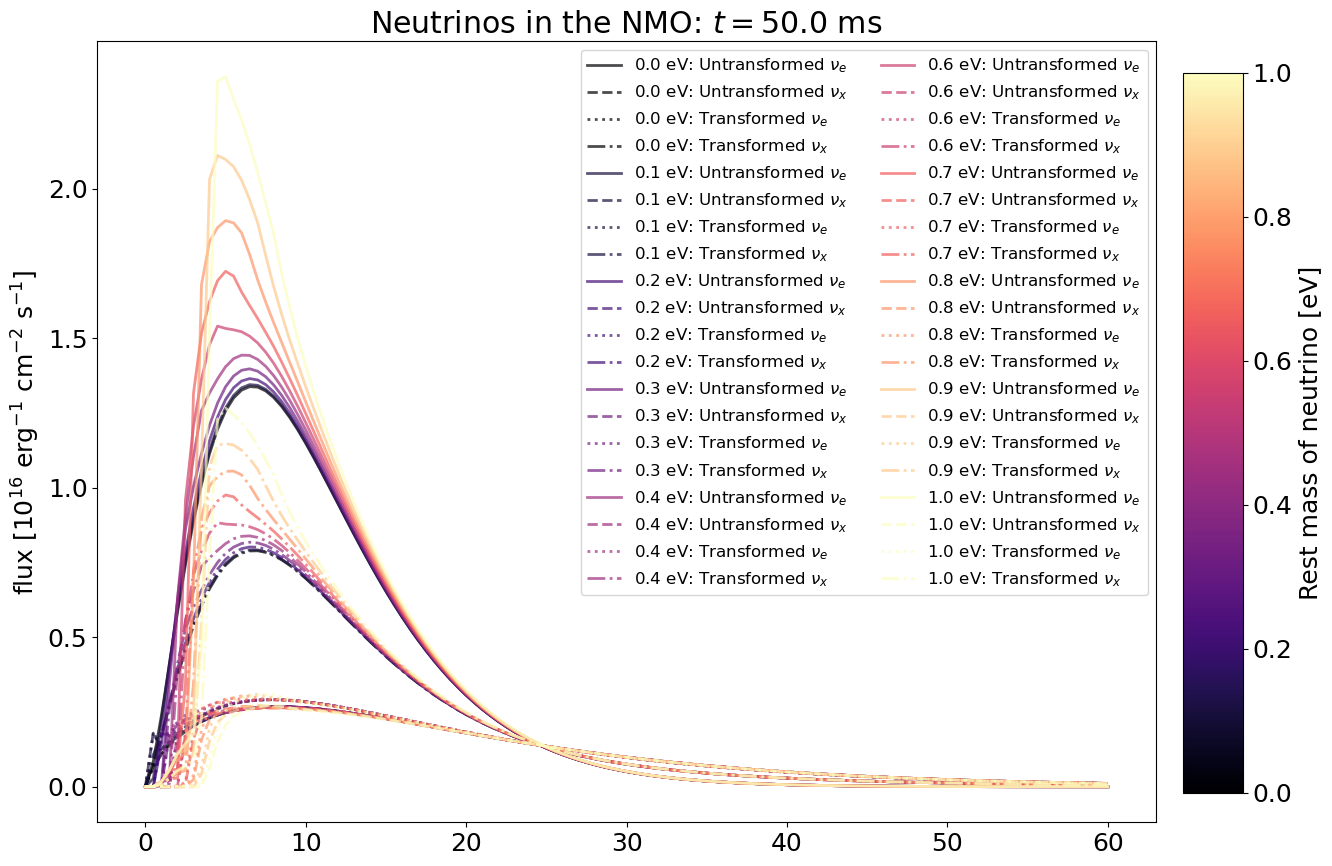

In [500]:
#zooming in on 0-1 eV range

model = Nakazato_2013(progenitor_mass=13*u.solMass, revival_time=100*u.ms, metallicity=0.02, eos='shen')

energies = np.linspace(0,60,121) * u.MeV
masses = [0, 0.1, 0.5, 1, 2.5, 5, 7.5, 10, 15, 20, 25, 50, 100] * u.eV
masses = np.logspace(0,3,25)  / 10 * u.eV
masses = np.linspace(0,1,10)  * u.eV
print(masses)

distance= 10 * u.kpc
arrival_time = 50 * u.ms

X = np.linspace(0,1,len(masses))
colors = []
for x in X:
    color = plt.cm.magma(x)
    colors += [color[:3]]
    
im = plt.scatter(X, X, c = masses, cmap = 'magma') #throwaway plot just to get colorbar


fig, axes = plt.subplots(1,1, figsize=(12,9), sharex=True, sharey=True, tight_layout=True)


for j in range(len(masses)):

    delayed_spectra, delayed_transformed_spectra_nmo, delayed_transformed_spectra_imo = get_delayed_flux(distance, arrival_time, energies, masses[j], model)
        
    for i, spec in enumerate([delayed_spectra, delayed_transformed_spectra_nmo]):
        axes.plot(energies, spec[Flavor.NU_E]/1e16, 
                    label=('{:.1f}: Untransformed '.format(masses[j])+Flavor.NU_E.to_tex()) if i==0 else '{:.1f}: Transformed '.format(masses[j])+Flavor.NU_E.to_tex(),
                    color=colors[j], ls='-' if i==0 else ':', lw=2,  alpha=0.7)
        axes.plot(energies, spec[Flavor.NU_X]/1e16, 
                    label='{:.1f}: Untransformed '.format(masses[j])+Flavor.NU_X.to_tex() if i==0 else '{:.1f}: Transformed '.format(masses[j])+Flavor.NU_X.to_tex(),
                    color=colors[j], ls='--' if i==0 else '-.', lw=2,  alpha=0.7)

axes.set(title='Neutrinos in the NMO: $t = ${:.1f}'.format(arrival_time))

axes.legend(loc='upper right', ncol=2, fontsize=12)


axes.set(ylabel=r'flux [$10^{16}$ erg$^{-1}$ cm$^{-2}$ s$^{-1}$]')

fig.subplots_adjust(right=1)
cbar_axes = fig.add_axes([1.0, 0.10, 0.05, 0.8])
cbar = fig.colorbar(im, cax=cbar_axes)
cbar.set_label('Rest mass of neutrino [eV]')


[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5] eV


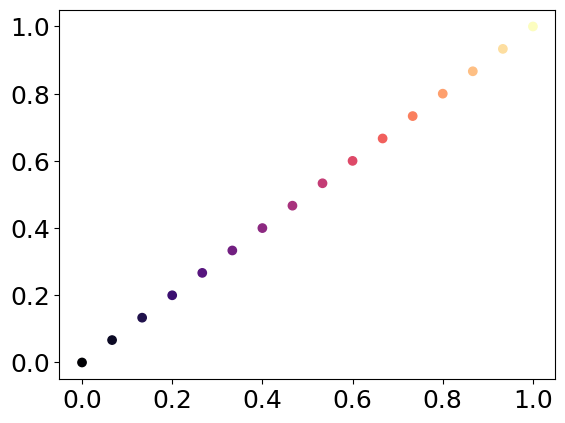

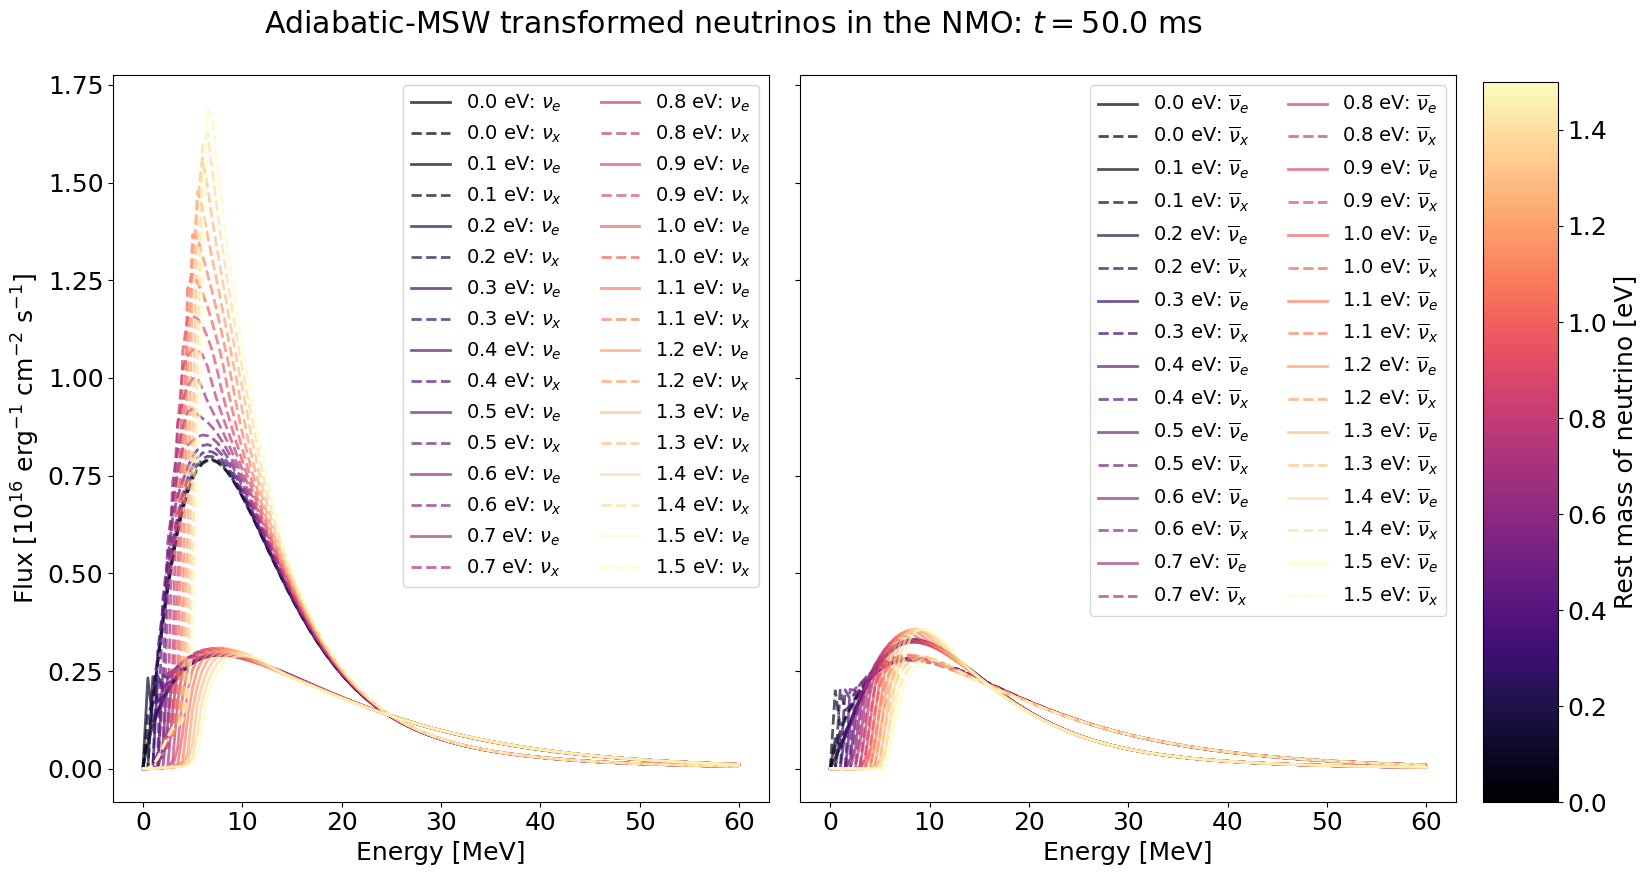

In [532]:
#zooming in on 0-1 eV range

model = Nakazato_2013(progenitor_mass=13*u.solMass, revival_time=100*u.ms, metallicity=0.02, eos='shen')
masses = np.linspace(0,1.5,16)  * u.eV
print(masses)

distance= 10 * u.kpc
arrival_time = 50 * u.ms

X = np.linspace(0,1,len(masses))
colors = []
for x in X:
    color = plt.cm.magma(x)
    colors += [color[:3]]

im = plt.scatter(X, X, c = masses, cmap = 'magma') #throwaway plot just to get colorbar

fig, axes = plt.subplots(1,2, figsize=(15,9), sharex=True, sharey=True, tight_layout=True)

for j in range(len(masses)):

    delayed_spectra, delayed_transformed_spectra_nmo, delayed_transformed_spectra_imo = get_delayed_flux(distance, arrival_time, energies, masses[j], model)
    
    for i, spec in enumerate([delayed_spectra, delayed_transformed_spectra_nmo]):
        if i == 1:
            axes[0].plot(energies, spec[Flavor.NU_E]/1e16, 
                    label='{:.1f}: '.format(masses[j])+Flavor.NU_E.to_tex(),
                    color=colors[j], ls='-', lw=2,  alpha=0.7)
            axes[0].plot(energies, spec[Flavor.NU_X]/1e16, 
                    label='{:.1f}: '.format(masses[j])+Flavor.NU_X.to_tex(),
                    color=colors[j], ls='--', lw=2,  alpha=0.7)
            axes[1].plot(energies, spec[Flavor.NU_E_BAR]/1e16, 
                    label='{:.1f}: '.format(masses[j])+Flavor.NU_E_BAR.to_tex(),
                    color=colors[j], ls='-', lw=2,  alpha=0.7)
            axes[1].plot(energies, spec[Flavor.NU_X_BAR]/1e16, 
                    label='{:.1f}: '.format(masses[j])+Flavor.NU_X_BAR.to_tex(),
                    color=colors[j], ls='--', lw=2,  alpha=0.7)
        else:
            pass  

fig.suptitle('Adiabatic-MSW transformed neutrinos in the NMO: $t = ${:.1f}'.format(arrival_time))

axes[0].legend(loc='upper right', ncol=2, fontsize=14)
axes[1].legend(loc='upper right', ncol=2, fontsize=14)

axes[0].set(xlabel = r'Energy [MeV]', ylabel=r'Flux [$10^{16}$ erg$^{-1}$ cm$^{-2}$ s$^{-1}$]')
axes[1].set(xlabel = r'Energy [MeV]')

fig.subplots_adjust(right=1)
cbar_axes = fig.add_axes([1.0, 0.10, 0.05, 0.8])
cbar = fig.colorbar(im, cax=cbar_axes)
cbar.set_label('Rest mass of neutrino [eV]')


[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5] eV


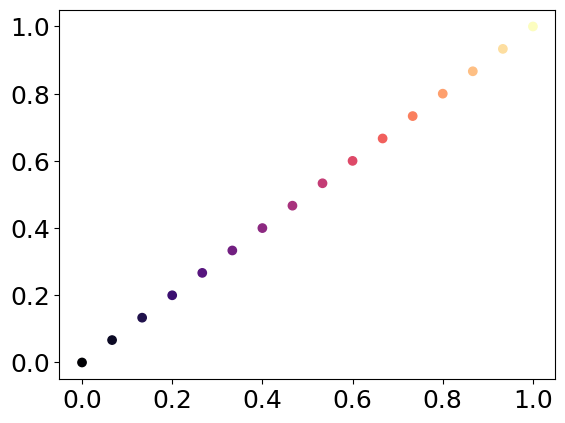

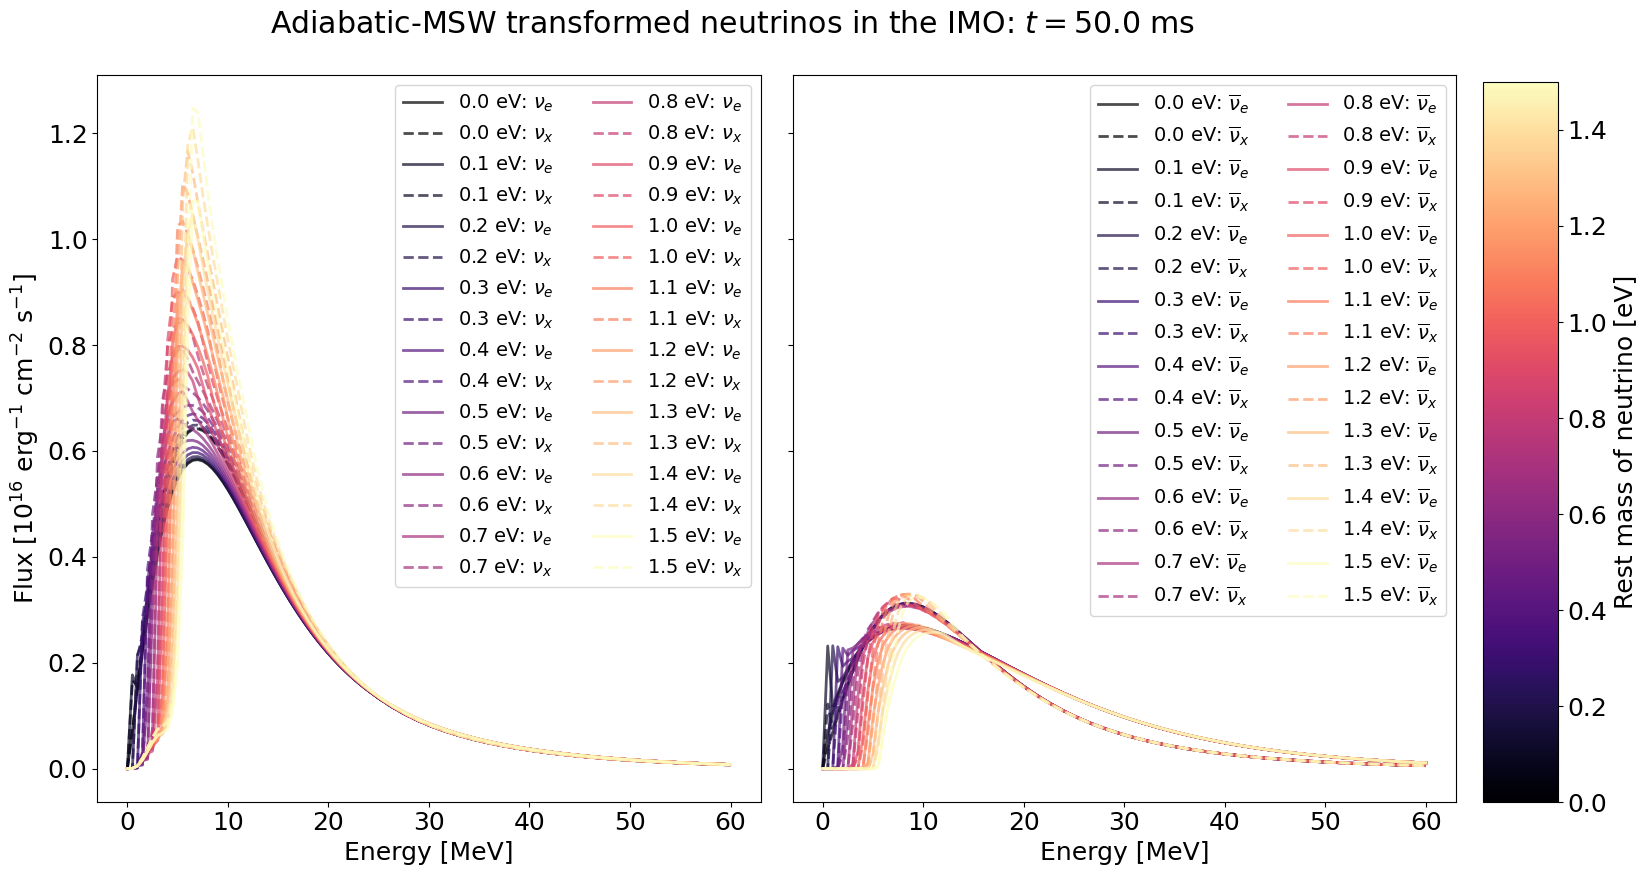

In [533]:
#zooming in on 0-1 eV range

model = Nakazato_2013(progenitor_mass=13*u.solMass, revival_time=100*u.ms, metallicity=0.02, eos='shen')
masses = np.linspace(0,1.5,16)  * u.eV
print(masses)

distance= 10 * u.kpc
arrival_time = 50 * u.ms

X = np.linspace(0,1,len(masses))
colors = []
for x in X:
    color = plt.cm.magma(x)
    colors += [color[:3]]

im = plt.scatter(X, X, c = masses, cmap = 'magma') #throwaway plot just to get colorbar

fig, axes = plt.subplots(1,2, figsize=(15,9), sharex=True, sharey=True, tight_layout=True)

for j in range(len(masses)):

    delayed_spectra, delayed_transformed_spectra_nmo, delayed_transformed_spectra_imo = get_delayed_flux(distance, arrival_time, energies, masses[j], model)
    
    for i, spec in enumerate([delayed_spectra, delayed_transformed_spectra_imo]):
        if i == 1:
            axes[0].plot(energies, spec[Flavor.NU_E]/1e16, 
                    label='{:.1f}: '.format(masses[j])+Flavor.NU_E.to_tex(),
                    color=colors[j], ls='-', lw=2,  alpha=0.7)
            axes[0].plot(energies, spec[Flavor.NU_X]/1e16, 
                    label='{:.1f}: '.format(masses[j])+Flavor.NU_X.to_tex(),
                    color=colors[j], ls='--', lw=2,  alpha=0.7)
            axes[1].plot(energies, spec[Flavor.NU_E_BAR]/1e16, 
                    label='{:.1f}: '.format(masses[j])+Flavor.NU_E_BAR.to_tex(),
                    color=colors[j], ls='-', lw=2,  alpha=0.7)
            axes[1].plot(energies, spec[Flavor.NU_X_BAR]/1e16, 
                    label='{:.1f}: '.format(masses[j])+Flavor.NU_X_BAR.to_tex(),
                    color=colors[j], ls='--', lw=2,  alpha=0.7)
        else:
            pass  

fig.suptitle('Adiabatic-MSW transformed neutrinos in the IMO: $t = ${:.1f}'.format(arrival_time))

axes[0].legend(loc='upper right', ncol=2, fontsize=14)
axes[1].legend(loc='upper right', ncol=2, fontsize=14)

axes[0].set(xlabel = r'Energy [MeV]', ylabel=r'Flux [$10^{16}$ erg$^{-1}$ cm$^{-2}$ s$^{-1}$]')
axes[1].set(xlabel = r'Energy [MeV]')

fig.subplots_adjust(right=1)
cbar_axes = fig.add_axes([1.0, 0.10, 0.05, 0.8])
cbar = fig.colorbar(im, cax=cbar_axes)
cbar.set_label('Rest mass of neutrino [eV]')


[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5] eV


/Users/jannahelgendy/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


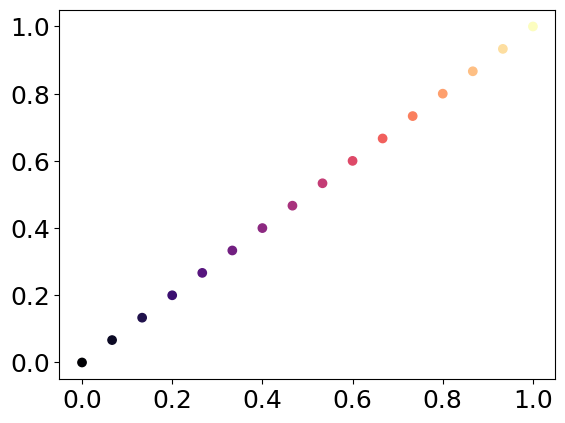

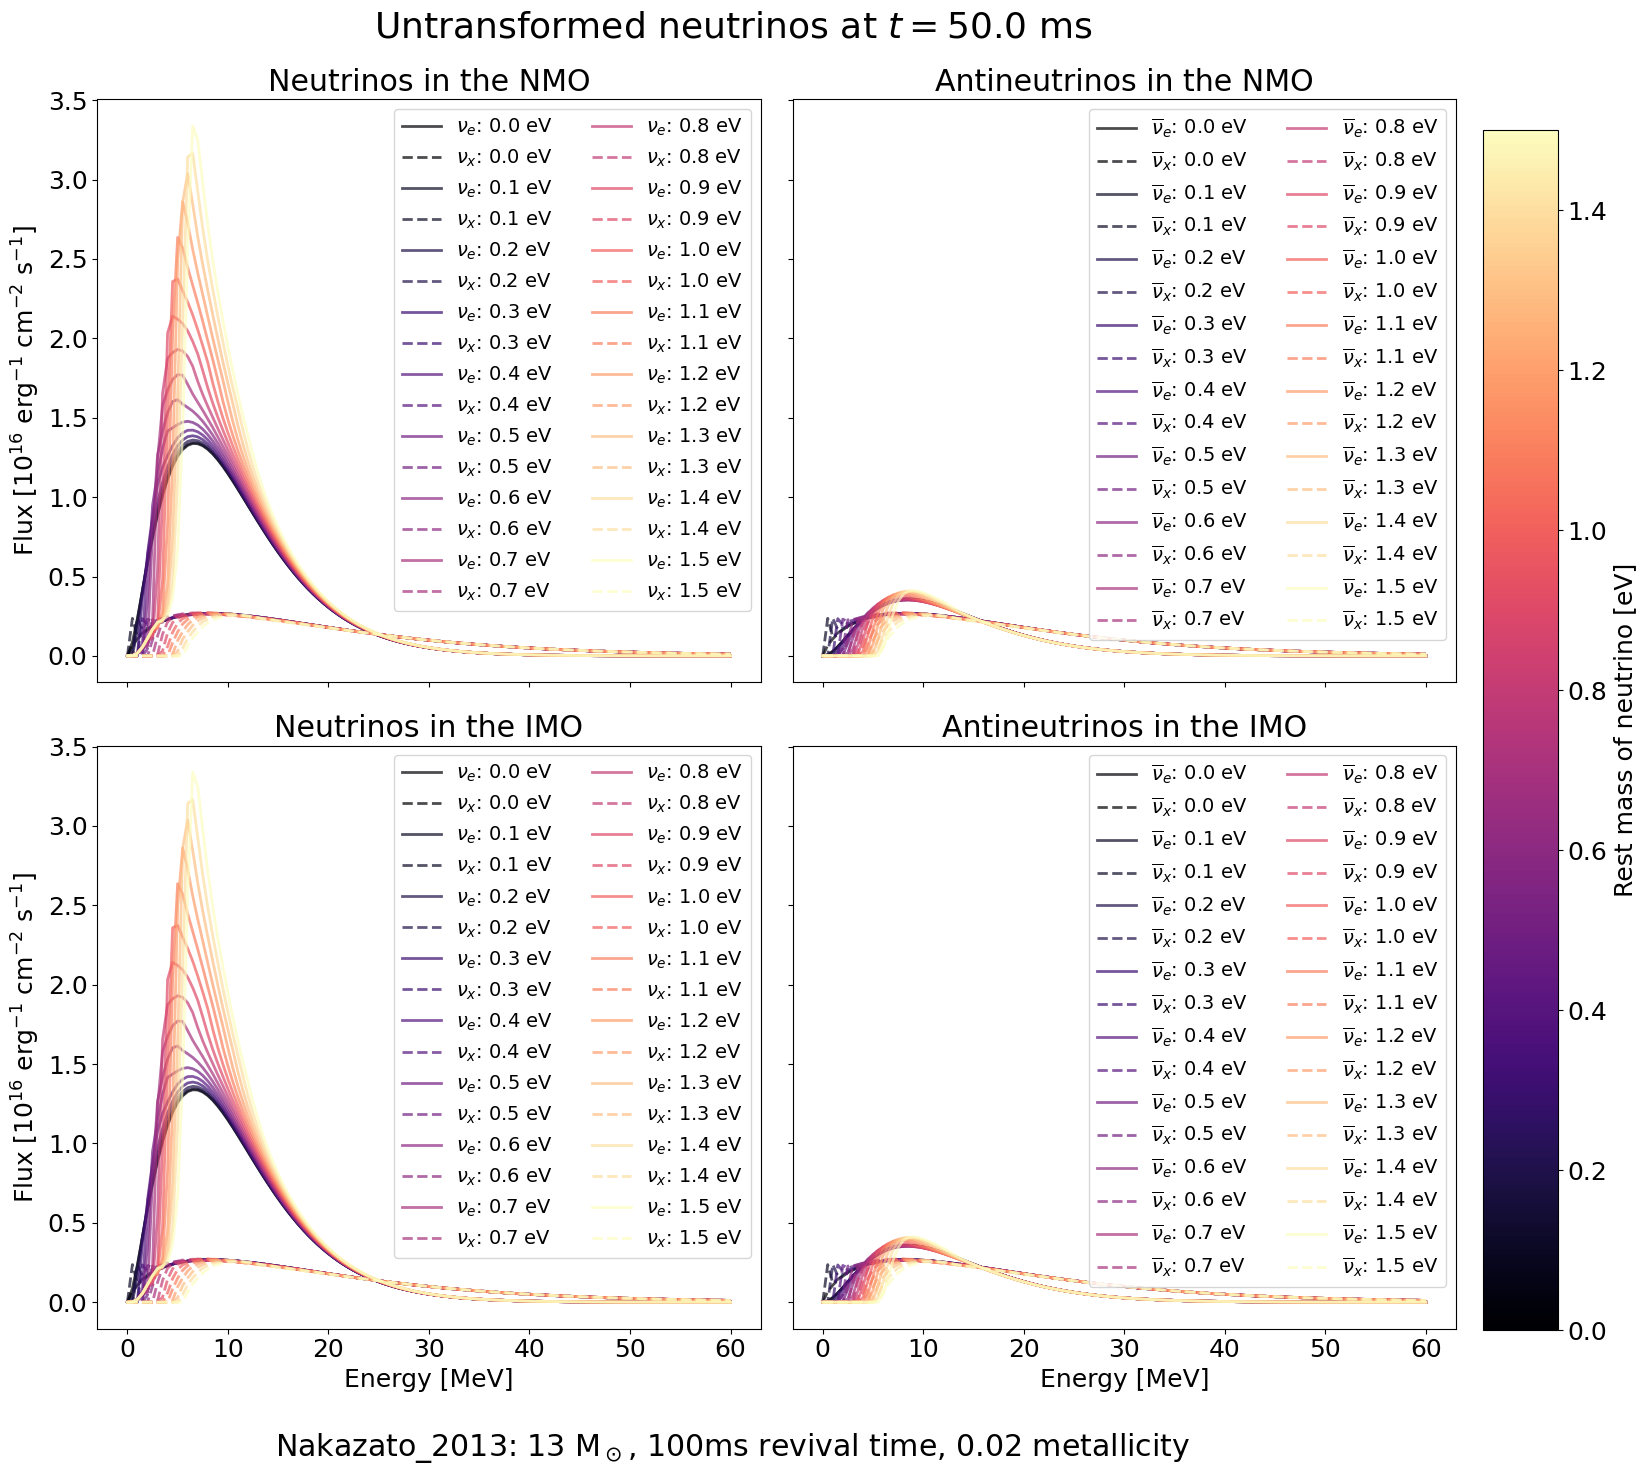

In [591]:
#zooming in on 0-1.5 eV range UNTRANSFORMED

model = Nakazato_2013(progenitor_mass=13*u.solMass, revival_time=100*u.ms, metallicity=0.02, eos='shen')
masses = np.linspace(0,1.5,16)  * u.eV
print(masses)

distance= 10 * u.kpc
arrival_time = 50 * u.ms

X = np.linspace(0,1,len(masses))
colors = []
for x in X:
    color = plt.cm.magma(x)
    colors += [color[:3]]

im = plt.scatter(X, X, c = masses, cmap = 'magma') #throwaway plot just to get colorbar

fig, axes = plt.subplots(2,2, figsize=(15,15), sharex=True, sharey=True, tight_layout=True)

for j in range(len(masses)):

    delayed_spectra, delayed_transformed_spectra_nmo, delayed_transformed_spectra_imo = get_delayed_flux(distance, arrival_time, energies, masses[j], model)
    
    for i, spec in enumerate([delayed_spectra, delayed_transformed_spectra_nmo]):
        if i == 0:
            axes[0][0].plot(energies, spec[Flavor.NU_E]/1e16, 
                    label=Flavor.NU_E.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='-', lw=2,  alpha=0.7)
            axes[0][0].plot(energies, spec[Flavor.NU_X]/1e16, 
                    label=Flavor.NU_X.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='--', lw=2,  alpha=0.7)
            axes[0][1].plot(energies, spec[Flavor.NU_E_BAR]/1e16, 
                    label=Flavor.NU_E_BAR.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='-', lw=2,  alpha=0.7)
            axes[0][1].plot(energies, spec[Flavor.NU_X_BAR]/1e16, 
                    label=Flavor.NU_X_BAR.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='--', lw=2,  alpha=0.7)
        else:
            pass
        
    for i, spec in enumerate([delayed_spectra, delayed_transformed_spectra_imo]):
        if i == 0:
            axes[1][0].plot(energies, spec[Flavor.NU_E]/1e16, 
                    label=Flavor.NU_E.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='-', lw=2,  alpha=0.7)
            axes[1][0].plot(energies, spec[Flavor.NU_X]/1e16, 
                    label=Flavor.NU_X.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='--', lw=2,  alpha=0.7)
            axes[1][1].plot(energies, spec[Flavor.NU_E_BAR]/1e16, 
                    label=Flavor.NU_E_BAR.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='-', lw=2,  alpha=0.7)
            axes[1][1].plot(energies, spec[Flavor.NU_X_BAR]/1e16, 
                    label=Flavor.NU_X_BAR.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='--', lw=2,  alpha=0.7)
        else:
            pass  

fig.suptitle('Untransformed neutrinos at $t = ${:.1f}'.format(arrival_time), fontsize=26)
fig.supxlabel("Nakazato_2013: 13 M$_\odot$, 100ms revival time, 0.02 metallicity")

axes[0][0].set(title='Neutrinos in the NMO')
axes[0][1].set(title='Antineutrinos in the NMO')
axes[1][0].set(title='Neutrinos in the IMO')
axes[1][1].set(title='Antineutrinos in the IMO')

axes[0][0].legend(loc='upper right', ncol=2, fontsize=14)
axes[0][1].legend(loc='upper right', ncol=2, fontsize=14)

axes[1][0].legend(loc='upper right', ncol=2, fontsize=14)
axes[1][1].legend(loc='upper right', ncol=2, fontsize=14)

axes[0][0].set(ylabel=r'Flux [$10^{16}$ erg$^{-1}$ cm$^{-2}$ s$^{-1}$]')
axes[1][0].set(xlabel = r'Energy [MeV]', ylabel=r'Flux [$10^{16}$ erg$^{-1}$ cm$^{-2}$ s$^{-1}$]')
axes[1][1].set(xlabel = r'Energy [MeV]')

fig.subplots_adjust(right=1)
cbar_axes = fig.add_axes([1.0, 0.10, 0.05, 0.8])
cbar = fig.colorbar(im, cax=cbar_axes)
cbar.set_label('Rest mass of neutrino [eV]')


[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.] eV


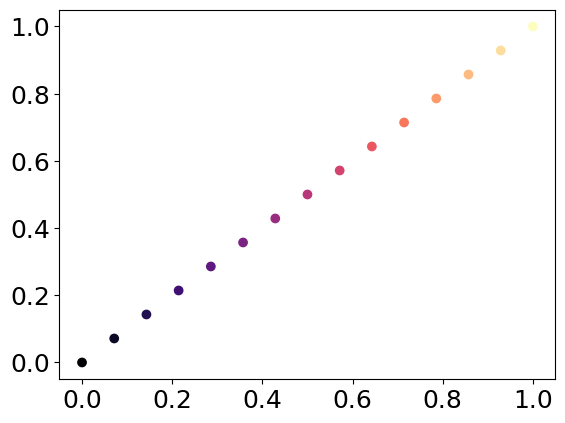

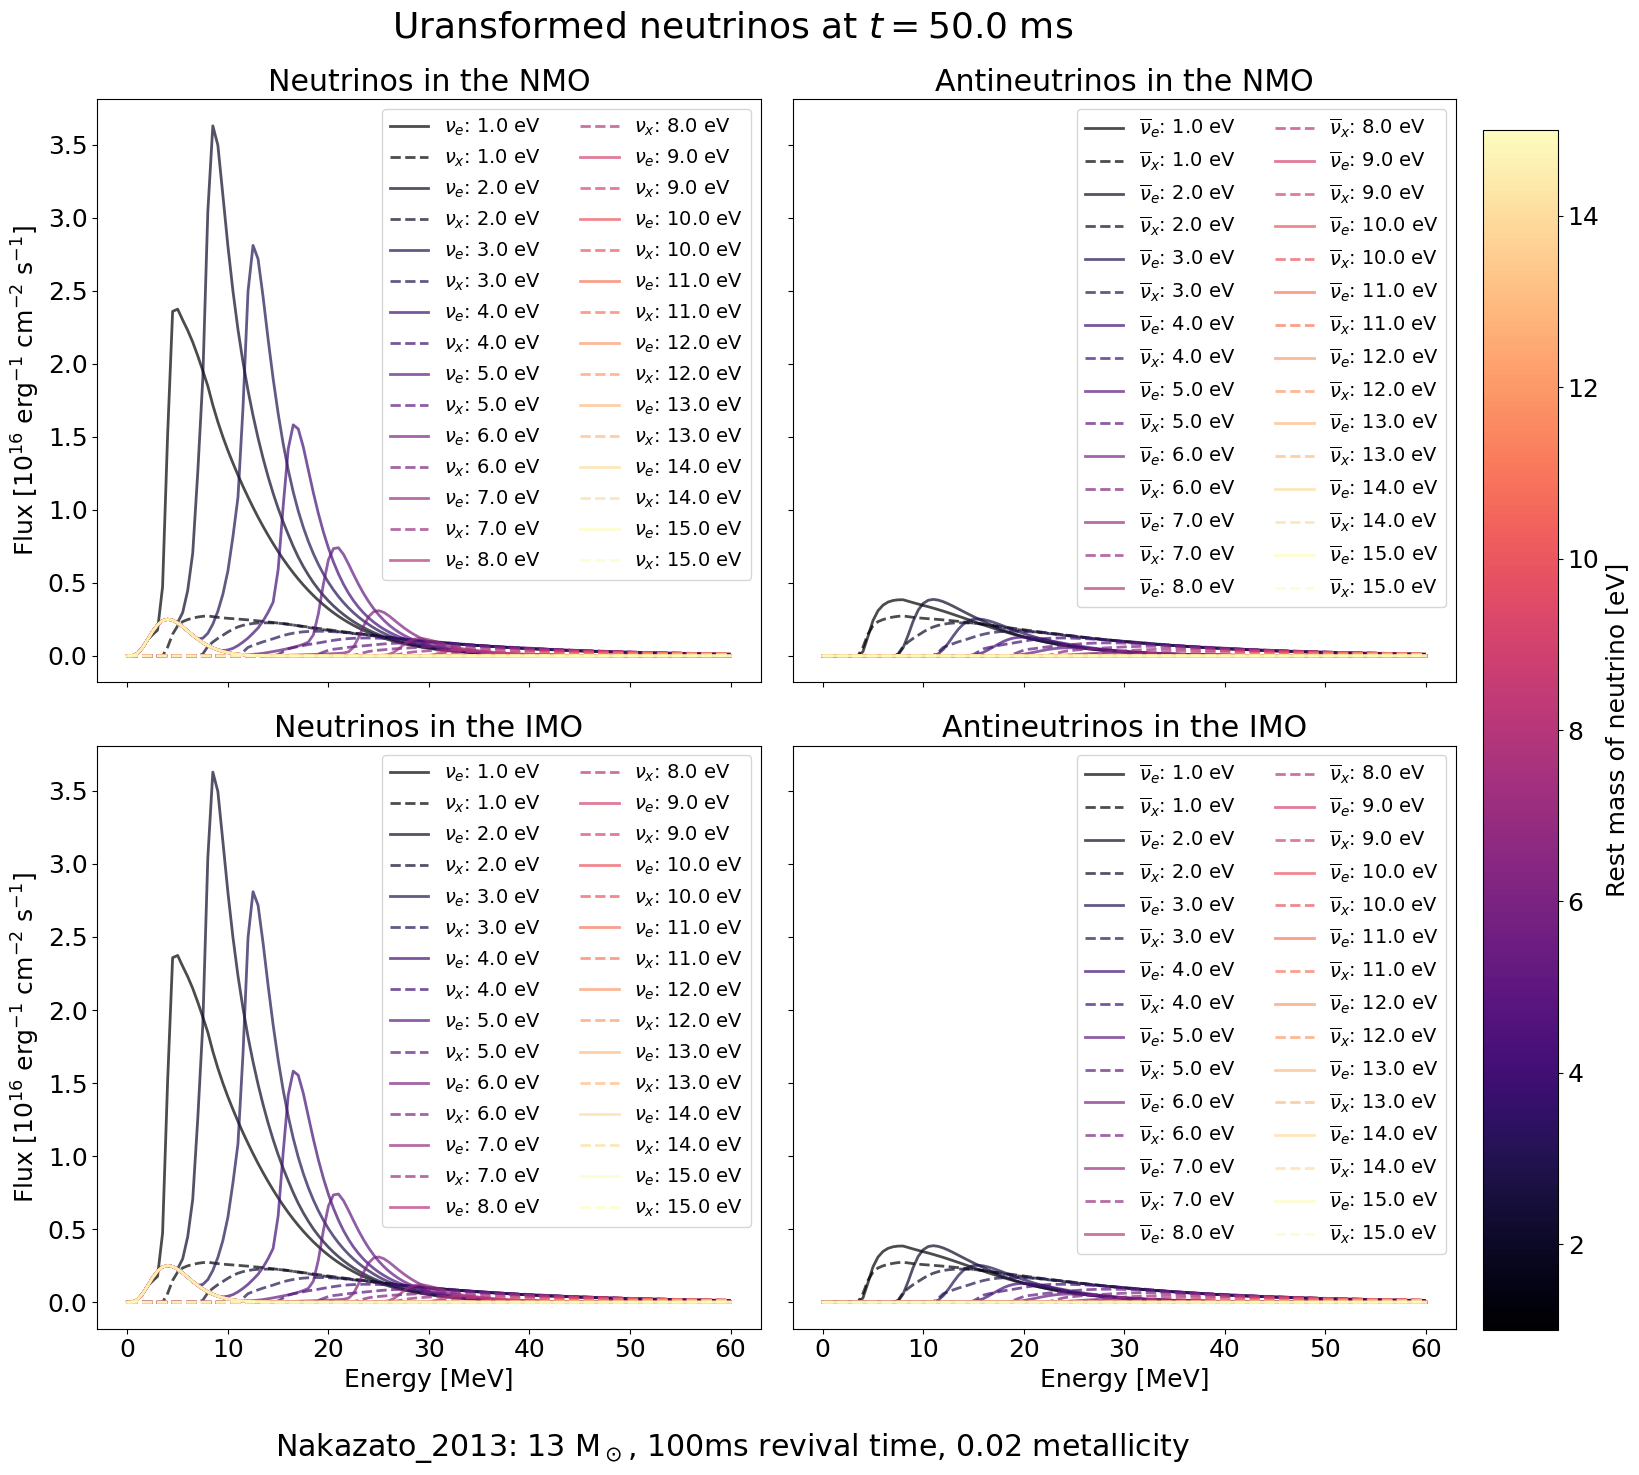

In [593]:
#zooming in on 1-100 eV range UNTRANSFORMED

model = Nakazato_2013(progenitor_mass=13*u.solMass, revival_time=100*u.ms, metallicity=0.02, eos='shen')
masses = np.logspace(0,2,15)  * u.eV
masses = np.linspace(1,15,15)  * u.eV

print(masses)

distance= 10 * u.kpc
arrival_time = 50 * u.ms

X = np.linspace(0,1,len(masses))
colors = []
for x in X:
    color = plt.cm.magma(x)
    colors += [color[:3]]

im = plt.scatter(X, X, c = masses, cmap = 'magma') #throwaway plot just to get colorbar

fig, axes = plt.subplots(2,2, figsize=(15,15), sharex=True, sharey=True, tight_layout=True)

for j in range(len(masses)):

    delayed_spectra, delayed_transformed_spectra_nmo, delayed_transformed_spectra_imo = get_delayed_flux(distance, arrival_time, energies, masses[j], model)
    
    for i, spec in enumerate([delayed_spectra, delayed_transformed_spectra_nmo]):
        if i == 0:
            axes[0][0].plot(energies, spec[Flavor.NU_E]/1e16, 
                    label=Flavor.NU_E.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='-', lw=2,  alpha=0.7)
            axes[0][0].plot(energies, spec[Flavor.NU_X]/1e16, 
                    label=Flavor.NU_X.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='--', lw=2,  alpha=0.7)
            axes[0][1].plot(energies, spec[Flavor.NU_E_BAR]/1e16, 
                    label=Flavor.NU_E_BAR.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='-', lw=2,  alpha=0.7)
            axes[0][1].plot(energies, spec[Flavor.NU_X_BAR]/1e16, 
                    label=Flavor.NU_X_BAR.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='--', lw=2,  alpha=0.7)
        else:
            pass
        
    for i, spec in enumerate([delayed_spectra, delayed_transformed_spectra_imo]):
        if i == 0:
            axes[1][0].plot(energies, spec[Flavor.NU_E]/1e16, 
                    label=Flavor.NU_E.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='-', lw=2,  alpha=0.7)
            axes[1][0].plot(energies, spec[Flavor.NU_X]/1e16, 
                    label=Flavor.NU_X.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='--', lw=2,  alpha=0.7)
            axes[1][1].plot(energies, spec[Flavor.NU_E_BAR]/1e16, 
                    label=Flavor.NU_E_BAR.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='-', lw=2,  alpha=0.7)
            axes[1][1].plot(energies, spec[Flavor.NU_X_BAR]/1e16, 
                    label=Flavor.NU_X_BAR.to_tex()+': {:.1f}'.format(masses[j]),
                    color=colors[j], ls='--', lw=2,  alpha=0.7)
        else:
            pass  

fig.suptitle('Uransformed neutrinos at $t = ${:.1f}'.format(arrival_time), fontsize=26)
fig.supxlabel("Nakazato_2013: 13 M$_\odot$, 100ms revival time, 0.02 metallicity")

axes[0][0].set(title='Neutrinos in the NMO')
axes[0][1].set(title='Antineutrinos in the NMO')
axes[1][0].set(title='Neutrinos in the IMO')
axes[1][1].set(title='Antineutrinos in the IMO')

axes[0][0].legend(loc='upper right', ncol=2, fontsize=14)
axes[0][1].legend(loc='upper right', ncol=2, fontsize=14)

axes[1][0].legend(loc='upper right', ncol=2, fontsize=14)
axes[1][1].legend(loc='upper right', ncol=2, fontsize=14)

axes[0][0].set(ylabel=r'Flux [$10^{16}$ erg$^{-1}$ cm$^{-2}$ s$^{-1}$]')
axes[1][0].set(xlabel = r'Energy [MeV]', ylabel=r'Flux [$10^{16}$ erg$^{-1}$ cm$^{-2}$ s$^{-1}$]')
axes[1][1].set(xlabel = r'Energy [MeV]')

fig.subplots_adjust(right=1)
cbar_axes = fig.add_axes([1.0, 0.10, 0.05, 0.8])
cbar = fig.colorbar(im, cax=cbar_axes)
cbar.set_label('Rest mass of neutrino [eV]')


[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5] eV


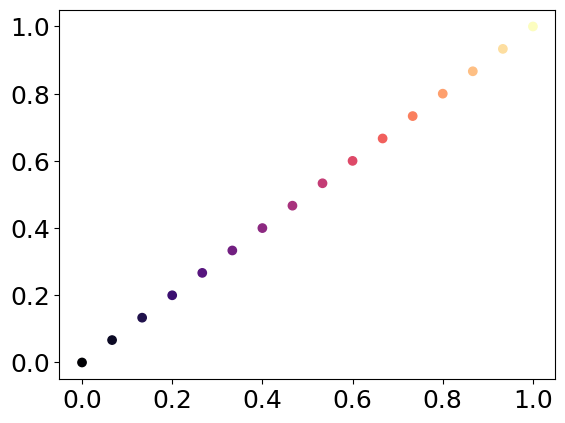

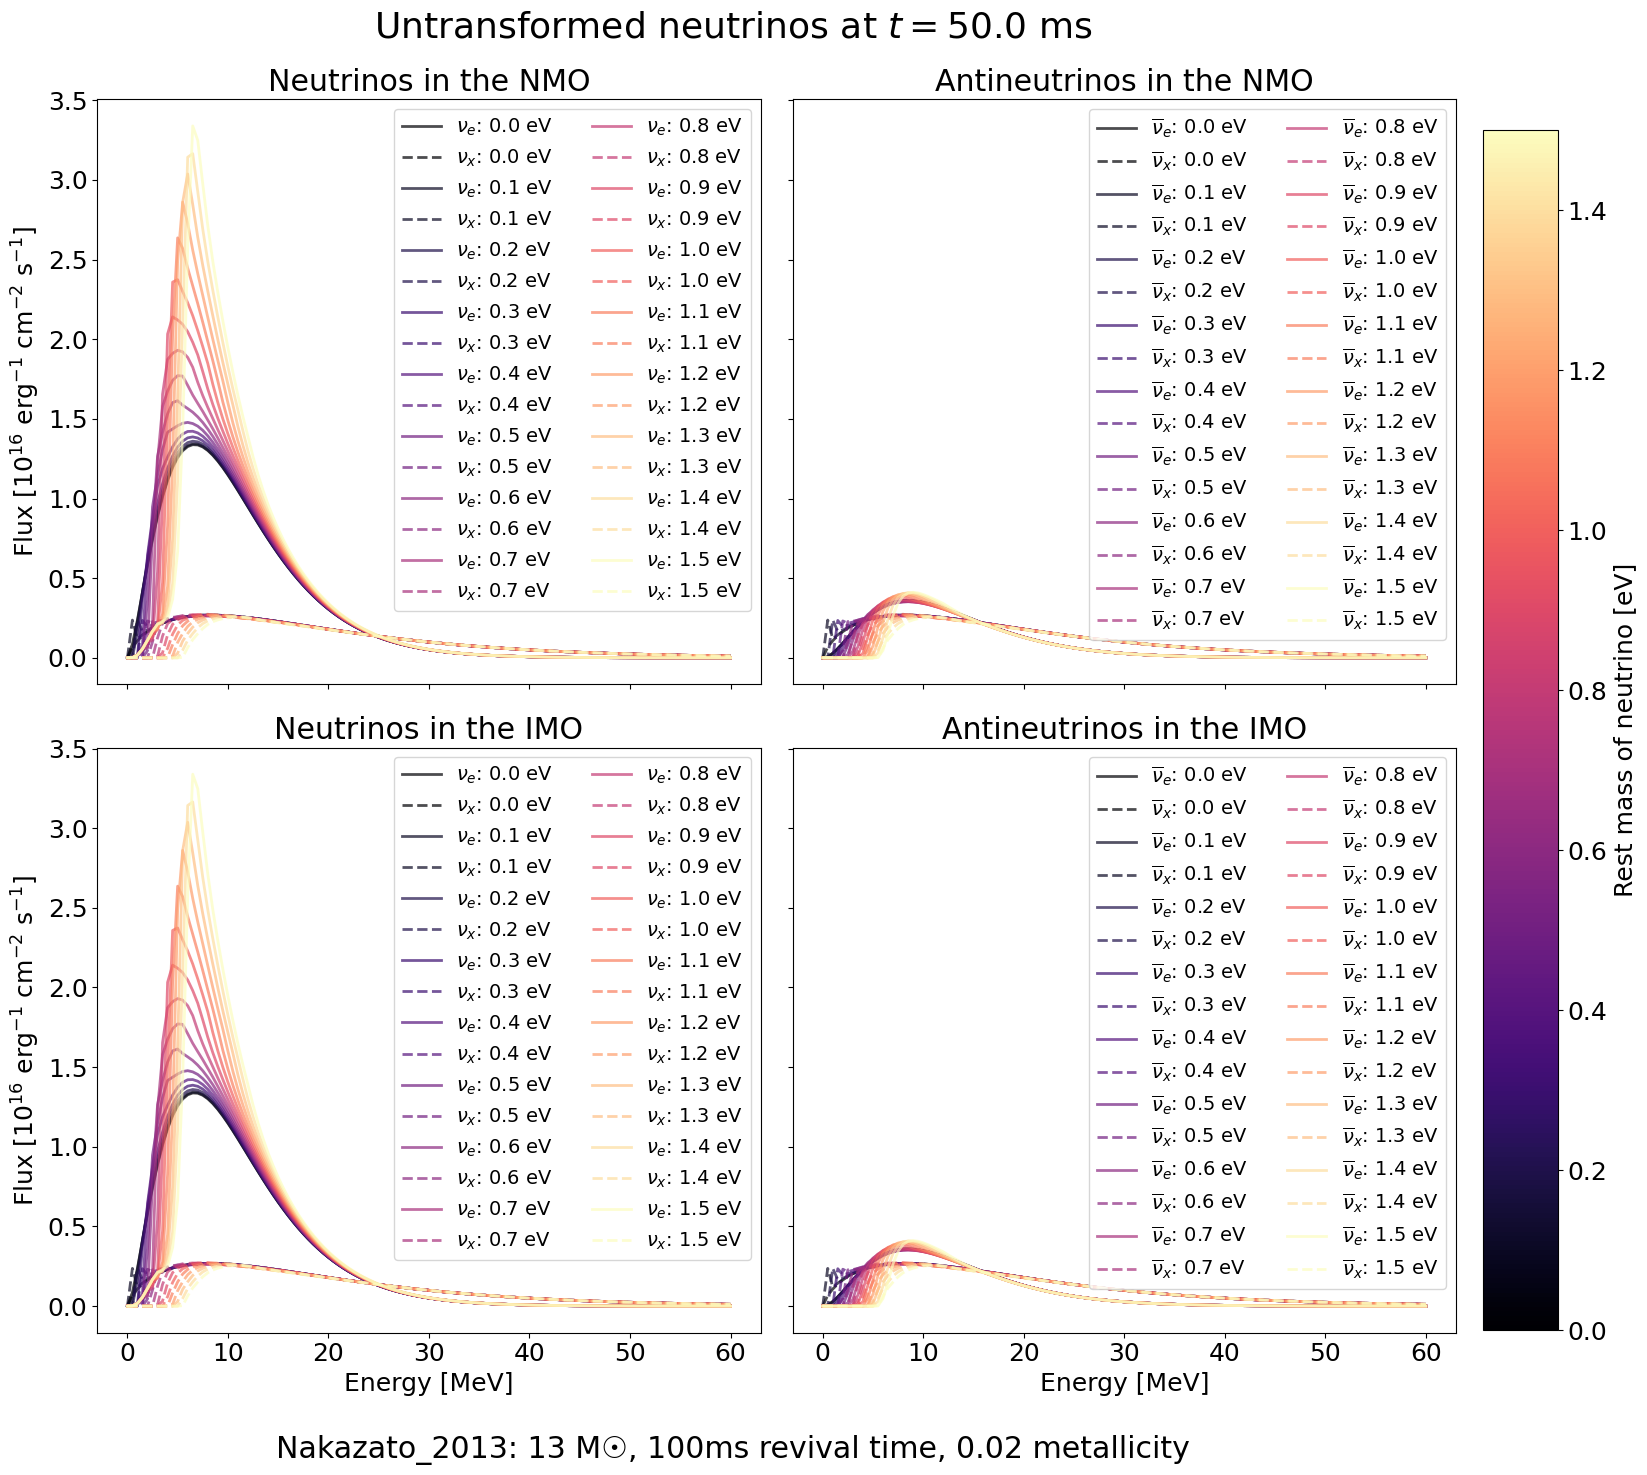

In [549]:

# UNTRANSFORMED

model = Nakazato_2013(progenitor_mass=13*u.solMass, revival_time=100*u.ms, metallicity=0.02, eos='shen')
masses = [0,1]  * u.eV
print(masses)

distance= 10 * u.kpc
arrival_time = 50 * u.ms

X = np.linspace(0,1,5)
colors = []
for x in X:
    color = plt.cm.magma(x)
    colors += [color[:3]]

im = plt.scatter(X, X, c = masses, cmap = 'magma') #throwaway plot just to get colorbar

fig, axes = plt.subplots(2,2, figsize=(15,15), sharex=True, sharey=True, tight_layout=True)


delayed_spectra, delayed_transformed_spectra_nmo, delayed_transformed_spectra_imo = get_delayed_flux(distance, arrival_time, energies, masses[j], model)

for i, spec in enumerate([delayed_spectra, delayed_transformed_spectra_nmo]):
    if i == 0:
        axes[0][0].plot(energies, spec[Flavor.NU_E]/1e16, 
                label='Delayed Untransformed '+Flavor.NU_E.to_tex(),
                color=colors[j], ls='-', lw=2,  alpha=0.7)
        axes[0][0].plot(energies, spec[Flavor.NU_X]/1e16, 
                label='Delayed Untransformed '+Flavor.NU_X.to_tex(),
                color=colors[j], ls='--', lw=2,  alpha=0.7)
        axes[0][1].plot(energies, spec[Flavor.NU_E_BAR]/1e16, 
                label='Delayed Untransformed '+Flavor.NU_E_BAR.to_tex(),
                color=colors[j], ls='-', lw=2,  alpha=0.7)
        axes[0][1].plot(energies, spec[Flavor.NU_X_BAR]/1e16, 
                label='Delayed Untransformed '+Flavor.NU_X_BAR.to_tex(),
                color=colors[j], ls='--', lw=2,  alpha=0.7)
    else:
        axes[0][0].plot(energies, spec[Flavor.NU_E]/1e16, 
                label='Delayed Untransformed '+Flavor.NU_E.to_tex(),
                color=colors[j], ls='-', lw=2,  alpha=0.7)
        axes[0][0].plot(energies, spec[Flavor.NU_X]/1e16, 
                label='Delayed Untransformed '+Flavor.NU_X.to_tex(),
                color=colors[j], ls='--', lw=2,  alpha=0.7)
        axes[0][1].plot(energies, spec[Flavor.NU_E_BAR]/1e16, 
                label='Delayed Untransformed '+Flavor.NU_E_BAR.to_tex(),
                color=colors[j], ls='-', lw=2,  alpha=0.7)
        axes[0][1].plot(energies, spec[Flavor.NU_X_BAR]/1e16, 
                label='Delayed Untransformed '+Flavor.NU_X_BAR.to_tex(),
                color=colors[j], ls='--', lw=2,  alpha=0.7)

for i, spec in enumerate([delayed_spectra, delayed_transformed_spectra_imo]):
    if i == 0:
        axes[1][0].plot(energies, spec[Flavor.NU_E]/1e16, 
                label='Delayed Untransformed '+Flavor.NU_E.to_tex(),
                color=colors[j], ls='-', lw=2,  alpha=0.7)
        axes[1][0].plot(energies, spec[Flavor.NU_X]/1e16, 
                label='Delayed Untransformed '+Flavor.NU_X.to_tex(),
                color=colors[j], ls='--', lw=2,  alpha=0.7)
        axes[1][1].plot(energies, spec[Flavor.NU_E_BAR]/1e16, 
                label='Delayed Untransformed '+Flavor.NU_E_BAR.to_tex(),
                color=colors[j], ls='-', lw=2,  alpha=0.7)
        axes[1][1].plot(energies, spec[Flavor.NU_X_BAR]/1e16, 
                label='Delayed Untransformed '+Flavor.NU_X_BAR.to_tex()+,
                color=colors[j], ls='--', lw=2,  alpha=0.7)
    else:
        axes[1][0].plot(energies, spec[Flavor.NU_E]/1e16, 
                label='Delayed Transformed '+Flavor.NU_E.to_tex(),
                color=colors[j], ls='-', lw=2,  alpha=0.7)
        axes[1][0].plot(energies, spec[Flavor.NU_X]/1e16, 
                label='Delayed Transformed '+Flavor.NU_X.to_tex(),
                color=colors[j], ls='--', lw=2,  alpha=0.7)
        axes[1][1].plot(energies, spec[Flavor.NU_E_BAR]/1e16, 
                label='Delayed Transformed '+Flavor.NU_E_BAR.to_tex(),
                color=colors[j], ls='-', lw=2,  alpha=0.7)
        axes[1][1].plot(energies, spec[Flavor.NU_X_BAR]/1e16, 
                label='Delayed Transformed '+Flavor.NU_X_BAR.to_tex(),
                color=colors[j], ls='--', lw=2,  alpha=0.7)

fig.suptitle('Untransformed neutrinos at $t = ${:.1f}'.format(arrival_time), fontsize=26)
fig.supxlabel("Nakazato_2013: 13 M$_\odot$, 100ms revival time, 0.02 metallicity")

axes[0][0].set(title='Neutrinos in the NMO')
axes[0][1].set(title='Antineutrinos in the NMO')
axes[1][0].set(title='Neutrinos in the IMO')
axes[1][1].set(title='Antineutrinos in the IMO')

axes[0][0].legend(loc='upper right', ncol=2, fontsize=14)
axes[0][1].legend(loc='upper right', ncol=2, fontsize=14)

axes[1][0].legend(loc='upper right', ncol=2, fontsize=14)
axes[1][1].legend(loc='upper right', ncol=2, fontsize=14)

axes[0][0].set(ylabel=r'Flux [$10^{16}$ erg$^{-1}$ cm$^{-2}$ s$^{-1}$]')
axes[1][0].set(xlabel = r'Energy [MeV]', ylabel=r'Flux [$10^{16}$ erg$^{-1}$ cm$^{-2}$ s$^{-1}$]')
axes[1][1].set(xlabel = r'Energy [MeV]')

fig.subplots_adjust(right=1)
cbar_axes = fig.add_axes([1.0, 0.10, 0.05, 0.8])
cbar = fig.colorbar(im, cax=cbar_axes)
cbar.set_label('Rest mass of neutrino [eV]')


# Event Rate Calculation - unused

In [10]:
#Trying to get event rates (more complex event rate calcs are in SNOwGLoBES_usage)

#model = Bollig_2016(progenitor_mass=27*u.solMass)
model = Nakazato_2013(progenitor_mass=13*u.solMass, revival_time=100*u.ms, metallicity=0.02, eos='shen')

#define the sampling points
energy = np.linspace(0,100,51)<<u.MeV
time = np.linspace(0,10,1000)<<u.s

#calculate the flux
flux = model.get_flux(time, energy, distance=10<<u.kpc, flavor_xform=AdiabaticMSW())
#print(flux.shape)

#optionally: integrate the flux over time bins to obtain the fluence
fluence = flux.integrate('time', limits=np.linspace(0,1,21)<<u.s)
#print(fluence.shape)

#calculate the event rates using the RateCalculator
from snewpy.rate_calculator import RateCalculator
rc = RateCalculator()
event_rates = rc.run(fluence, detector='km3net') #select the detector/material, whether to account for effects, etc
ibd_rate = event_rates['ibd'] #will be also a Container instance
#print(ibd_rate)

#get the total values vs. time bin
N_ibd_vs_T = ibd_rate.sum('energy')
#or total values vs. energy bin
N_ibd_vs_E = ibd_rate.sum('time')
#or total number of interactions
N_ibd_tot = ibd_rate.sum('time').sum('energy')
#to retrieve the number we can access the `array` member
print(N_ibd_vs_T.array.squeeze().shape)
print(N_ibd_vs_E.array.squeeze().shape)

print(N_ibd_tot.array.squeeze()) #314074.77180403896


Using snowglobes_data module ...
(20,)
(200,)
9999.346951153426


/Users/jannahelgendy/opt/anaconda3/lib/python3.9/site-packages/snewpy/rate_calculator.py:42: RuntimeWarning: divide by zero encountered in log
  xsecs = np.interp(np.log(E)/np.log(10), xp, yp, left=0, right=0)*E*1e-38 <<u.cm**2


In [11]:
#finding the mixing angles - we only care about using adiabatic msw so we can skip this step 

mp_nmo = MixingParameters()
angles_nmo = mp_nmo.get_mixing_angles()
print(angles_nmo)

mp_imo = MixingParameters(mh=MassHierarchy.INVERTED)
angles_imo = mp_imo.get_mixing_angles()
print(angles_imo)

(<Quantity 33.44 deg>, <Quantity 8.57 deg>, <Quantity 49.2 deg>)
(<Quantity 33.45 deg>, <Quantity 8.6 deg>, <Quantity 49.3 deg>)


#assume all neutrinos have the same constant mass: therefore the time of flight distribution is proportional 
    #to the energy spectra
    
#try to animate how the energy dist changes over time?
fig = plot_spectra(model, AdiabaticMSW(), AdiabaticMSW(mh=MassHierarchy.INVERTED), 25*u.ms)
fig.suptitle("Spectra")
fig.supxlabel("Nakazato_2013: 13 M☉, 100ms revival, 0.02 metallicity")
fig.savefig('spectra_Adiabatic1.png')